Documentación pyedflib: https://pyedflib.readthedocs.io/en/latest/ref/edfreader.html

Documentación networkx: https://networkx.org/documentation/networkx-1.9/reference/index.html

Documentación csv: https://docs.python.org/3/library/csv.html

Información grafos: https://www.cienciadedatos.net/documentos/pygml01-introduccion-grafos-redes-python.html

Información igraph: https://igraph.org/python/tutorial/0.9.6

In [3]:
import pandas as pd
import numpy as np
import pyedflib
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from os.path import basename
from pprint import pprint

CHANNELS: tuple[str] = ('Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'T3', 'T4', 
                        'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2', 
                        'Fz', 'Cz', 'Pz')
N_CHANNELS: int = len(CHANNELS)

df_subject_info = pd.read_csv('Archivos\subject-info.csv')[['Subject', 'Count quality']]

In [4]:
# Convertir un archivo EDF a CSV

def edf_to_csv(filename: str, output_path: str = '') -> None:
    # Se guardan los archivos en una matriz 19 x No. Señales (31000 o 91000)

    f: pyedflib.EdfReader = pyedflib.EdfReader(filename)
    
    signals: np.zeros = np.zeros((N_CHANNELS + 1, m := f.getNSamples()[0]))
    signals[0, :] = np.arange(1, m + 1) # Es la cabecera de las columnas que son numeros desde el 1 al No. Señales
    for i in np.arange(1, N_CHANNELS + 1):
        signals[i, :]= f.readSignal(i - 1)

    np.savetxt(output_path + basename(filename.replace('.edf', '.csv')), signals, delimiter=';')

    f.close()

In [5]:
# Funciones a partir de la ruta

def get_distances(path: str) -> pd.DataFrame:
    df: pd.DataFrame = pd.read_csv(path, sep=';')

    df['EEG channels'] = CHANNELS
    df = df.set_index('EEG channels')

    df = np.transpose(df)

    # Hacer la matriz de correlación
    df_correlation: pd.DataFrame = df.corr()

    # Hacer la matriz de distancias a partir de la correlación
    # Dij = sqrt(2*(1-Cij))
    df_distances: pd.DataFrame = pd.DataFrame(np.sqrt(2 * (1 - df_correlation)), index=CHANNELS, columns=CHANNELS)

    return df_distances

def get_mst(path: str) -> nx.Graph:
    df_distances: pd.DataFrame = get_distances(path)

    edges = df_distances.stack().reset_index()
    edges.columns = ["target", "source", "weight"]
    edges = edges.loc[edges["target"] != edges["source"]].copy()

    # Quitar las columnas repetidas
    edges['sorted_columns'] = np.sort(edges[['target', 'source']], axis=1).tolist()
    edges.drop_duplicates(subset='sorted_columns', keep='first', inplace=True)
    edges.drop('sorted_columns', axis=1, inplace=True)

    g0 = nx.from_pandas_edgelist(edges, "target", "source", edge_attr=["weight"])
    return nx.minimum_spanning_tree(g0)

def centrality(path: str) -> pd.DataFrame:
    mst_g0 = get_mst(path)

    degree_centrality = nx.degree_centrality(mst_g0)
    betweenness_centrality = nx.betweenness_centrality(mst_g0)
    closeness_centrality = nx.closeness_centrality(mst_g0)
    pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

    return pd.DataFrame({
        'nodes': CHANNELS,
        'degree': degree_centrality.values(),
        'betweenness': betweenness_centrality.values(),
        'closeness': closeness_centrality.values(),
        'pagerank': pagerank.values()
    })

In [6]:
# Funciones a partir de la matriz de distancias

def get_mst_from_df(df_distances: pd.DataFrame) -> nx.Graph:
    edges = df_distances.stack().reset_index()
    edges.columns = ["target", "source", "weight"]
    edges = edges.loc[edges["target"] != edges["source"]].copy()

    # Quitar las columnas repetidas
    edges['sorted_columns'] = np.sort(edges[['target', 'source']], axis=1).tolist()
    edges.drop_duplicates(subset='sorted_columns', keep='first', inplace=True)
    edges.drop('sorted_columns', axis=1, inplace=True)

    g0 = nx.from_pandas_edgelist(edges, "target", "source", edge_attr=["weight"])
    return nx.minimum_spanning_tree(g0)

def get_centrality_from_df(df_distances: pd.DataFrame) -> pd.DataFrame:
    mst_g0 = get_mst_from_df(df_distances)

    degree_centrality = nx.degree_centrality(mst_g0)
    betweenness_centrality = nx.betweenness_centrality(mst_g0)
    closeness_centrality = nx.closeness_centrality(mst_g0)
    pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

    return pd.DataFrame({
        'nodes': CHANNELS,
        'degree': degree_centrality.values(),
        'betweenness': betweenness_centrality.values(),
        'closeness': closeness_centrality.values(),
        'pagerank': pagerank.values()
    })

In [8]:
path: str = 'Archivos\\Subject00\\csv\\Subject00_1.csv'
df: pd.DataFrame = pd.read_csv(path, sep=';')

df['EEG channels'] = CHANNELS
df = df.set_index('EEG channels')

df = np.transpose(df)

# Hacer la matriz de correlación
df_correlation: pd.DataFrame = df.corr()

# Obtener las listas de las distancias a partir de las correlaciones
# Dij = sqrt(2 * (1 - Cij))

df_distances: pd.DataFrame = pd.DataFrame(np.sqrt(2 * (1 - df_correlation)), index=CHANNELS, columns=CHANNELS)

df_distances

,Fp1,Fp2,F3,F4,F7,F8,T3,T4,C3,C4,T5,T6,P3,P4,O1,O2,Fz,Cz,Pz
Fp1,0.000000,0.380983,0.384847,0.517847,0.880920,0.700337,1.071883,1.066620,0.807208,0.813368,1.302779,1.392313,1.189435,1.298252,1.400957,1.538277,0.518112,0.806937,1.190570
Fp2,0.380983,0.000000,0.697360,0.598279,1.013641,0.696905,1.188792,1.079792,0.960270,0.897637,1.369441,1.368406,1.260405,1.301219,1.441069,1.523528,0.600115,0.928121,1.241305
F3,0.384847,0.697360,0.000000,0.603887,0.898176,0.860300,1.071711,1.022022,0.731026,0.798899,1.248554,1.347991,1.151257,1.239262,1.379895,1.508072,0.575017,0.775986,1.136650
F4,0.517847,0.598279,0.603887,0.000000,0.991475,0.727173,1.156642,0.957711,0.865027,0.730232,1.308427,1.306526,1.190179,1.221838,1.389200,1.485980,0.341589,0.815467,1.166356
F7,0.880920,1.013641,0.898176,0.991475,0.000000,1.083738,1.154421,1.215040,1.034662,1.099575,1.339427,1.410324,1.268890,1.355821,1.426727,1.519220,0.988357,1.091270,1.286516
F8,0.700337,0.696905,0.860300,0.727173,1.083738,0.000000,1.248493,1.067098,1.024169,0.932251,1.393530,1.315365,1.274071,1.267027,1.413404,1.481438,0.710167,0.997728,1.234041
T3,1.071883,1.188792,1.071711,1.156642,1.154421,1.248493,0.000000,1.149336,0.909472,1.061707,0.944602,1.298950,0.907844,1.164653,1.185955,1.391658,1.152284,1.072688,1.020366
T4,1.066620,1.079792,1.022022,0.957711,1.215040,1.067098,1.149336,0.000000,0.972863,0.528475,1.145156,0.546865,0.955883,0.594068,1.076563,1.072620,0.959902,0.906135,0.810389
C3,0.807208,0.960270,0.731026,0.865027,1.034662,1.024169,0.909472,0.972863,0.000000,0.751137,1.078627,1.230377,0.852083,1.045083,1.162479,1.361407,0.868847,0.811727,0.881790
C4,0.813368,0.897637,0.798899,0.730232,1.099575,0.932251,1.061707,0.528475,0.751137,0.000000,1.183938,0.967742,0.900196,0.798209,1.126034,1.235183,0.732104,0.716730,0.792637


In [9]:
edges = df_distances.stack().reset_index()

edges.columns = ["target", "source", "weight"]

edges = edges.loc[edges["target"] != edges["source"]].copy()

# Eliminar los valores duplicados (gracias chatgpt)
edges['sorted_columns'] = np.sort(edges[['target', 'source']], axis=1).tolist()
edges.drop_duplicates(subset='sorted_columns', keep='first', inplace=True)
edges.drop('sorted_columns', axis=1, inplace=True)

edges

,target,source,weight
1,Fp1,Fp2,0.380983
2,Fp1,F3,0.384847
3,Fp1,F4,0.517847
4,Fp1,F7,0.880920
5,Fp1,F8,0.700337
...,...,...,...
302,O2,Cz,1.362736
303,O2,Pz,0.934280
321,Fz,Cz,0.824791
322,Fz,Pz,1.168854


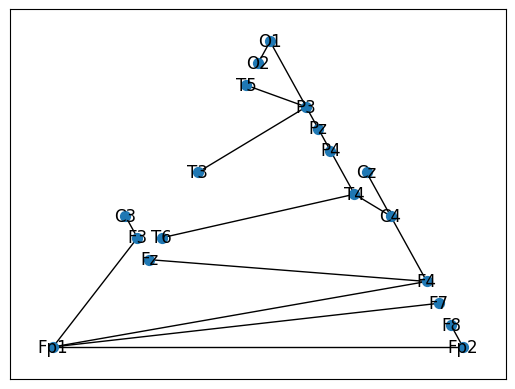

In [11]:
# mst sujeto00 antes

g0 = nx.from_pandas_edgelist(edges, "target", "source", edge_attr=["weight"])
mst_g0 = nx.minimum_spanning_tree(g0)

nx.draw_networkx(
    mst_g0,
    nx.planar_layout(mst_g0),
    node_size=50
)

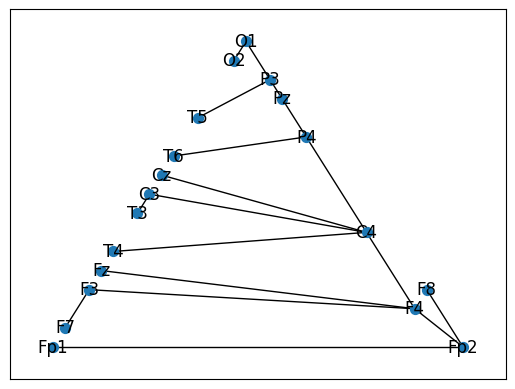

In [12]:
# mst sujeto00 durante

mst_g1 = get_mst('Archivos\\Subject00\\csv\\Subject00_2.csv')
nx.draw_networkx(
    mst_g1,
    nx.planar_layout(mst_g1),
    node_size=50
)

In [13]:
density = nx.density(mst_g0)
ave_clustering = nx.average_clustering(mst_g0)

print(f'Density: {density}')
print(f'Average clustering: {ave_clustering}\n')

degree_centrality = nx.degree_centrality(mst_g0)
print('Degree centrality:')
pprint(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

betweenness_centrality = nx.betweenness_centrality(mst_g0)
print('\nBetweness centrality')
pprint(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

closeness_centrality = nx.closeness_centrality(mst_g0)
print('\nClossenes centrality')
pprint(sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)
print('\nPagerank')
pprint(sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5])

Density: 0.10526315789473684
Average clustering: 0.0

Degree centrality:
[('Fp1', 0.2222222222222222),
 ('P3', 0.2222222222222222),
 ('F4', 0.16666666666666666),
 ('T4', 0.16666666666666666),
 ('C4', 0.16666666666666666)]

Betweness centrality
[('C4', 0.5816993464052288),
 ('T4', 0.5686274509803921),
 ('F4', 0.542483660130719),
 ('Fp1', 0.477124183006536),
 ('P4', 0.47058823529411764)]

Clossenes centrality
[('C4', 0.32142857142857145),
 ('T4', 0.3157894736842105),
 ('F4', 0.3050847457627119),
 ('P4', 0.2903225806451613),
 ('Fp1', 0.2727272727272727)]

Pagerank
[('P3', 0.10972118843902842),
 ('Fp1', 0.09441549482198572),
 ('C4', 0.08446214111230474),
 ('T4', 0.07367667841667408),
 ('F4', 0.07143403418226048)]


In [14]:
# Datos para sacar los diagrama de barras para cada medida de centralidad
df_centrality = pd.DataFrame({
    'nodes': CHANNELS,
    'degree': degree_centrality.values(),
    'betweenness': betweenness_centrality.values(),
    'closeness': closeness_centrality.values(),
    'pagerank': pagerank.values()
})

df_centrality

,nodes,degree,betweenness,closeness,pagerank
0,Fp1,0.222222,0.477124,0.272727,0.094415
1,Fp2,0.111111,0.111111,0.222222,0.053917
2,F3,0.111111,0.111111,0.222222,0.054822
3,F4,0.166667,0.542484,0.305085,0.071434
4,F7,0.055556,0.000000,0.216867,0.040555
5,F8,0.055556,0.000000,0.183673,0.037525
6,T3,0.055556,0.000000,0.189474,0.038682
7,T4,0.166667,0.568627,0.315789,0.073677
8,C3,0.055556,0.000000,0.183673,0.038422
9,C4,0.166667,0.581699,0.321429,0.084462


In [ ]:
# Guarda las medidas de centralidad de los sujetos (antes y despues) en archivos

df_before = pd.DataFrame()
df_during = pd.DataFrame()

for i in range(0, 35 + 1):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    df_temp1 = pd.DataFrame({'subject': [subject]*19})
    df_temp1 = pd.concat([df_temp1, centrality(csv_path1)], axis=1)
    df_temp1['count_quality'] = ('G' if df_subject_info["Count quality"][i] == 1 else 'B')
    df_before = pd.concat([df_before, df_temp1], ignore_index=True)

    df_temp2 = pd.DataFrame({'subject': [subject]*19})
    df_temp2 = pd.concat([df_temp2, centrality(csv_path2)], axis=1)
    df_temp2['count_quality'] = ('G' if df_subject_info["Count quality"][i] == 1 else 'B')
    df_during = pd.concat([df_during, df_temp2], ignore_index=True)

df_before.to_csv('Archivos\centrality_before.csv', sep=';', index=False)
df_before.to_csv('Archivos\centrality_during.csv', sep=';', index=False)

In [16]:
df_before = pd.read_csv('Archivos\centrality_before.csv', delimiter=';')
df_before['state'] = 'before'

df_during = pd.read_csv('Archivos\centrality_during.csv', delimiter=';')
df_during['state'] = 'during'

df_result = pd.concat([df_before, df_during], ignore_index=True)
df_result

,subject,nodes,degree,betweenness,closeness,pagerank,count_quality,state
0,Subject00,Fp1,0.222222,0.477124,0.272727,0.094415,B,before
1,Subject00,Fp2,0.111111,0.111111,0.222222,0.053917,B,before
2,Subject00,F3,0.111111,0.111111,0.222222,0.054822,B,before
3,Subject00,F4,0.166667,0.542484,0.305085,0.071434,B,before
4,Subject00,F7,0.055556,0.000000,0.216867,0.040555,B,before
...,...,...,...,...,...,...,...,...
1363,Subject35,O1,0.055556,0.000000,0.180000,0.032810,G,during
1364,Subject35,O2,0.111111,0.111111,0.216867,0.053707,G,during
1365,Subject35,Fz,0.222222,0.542484,0.360000,0.089719,G,during
1366,Subject35,Cz,0.055556,0.000000,0.240000,0.031004,G,during


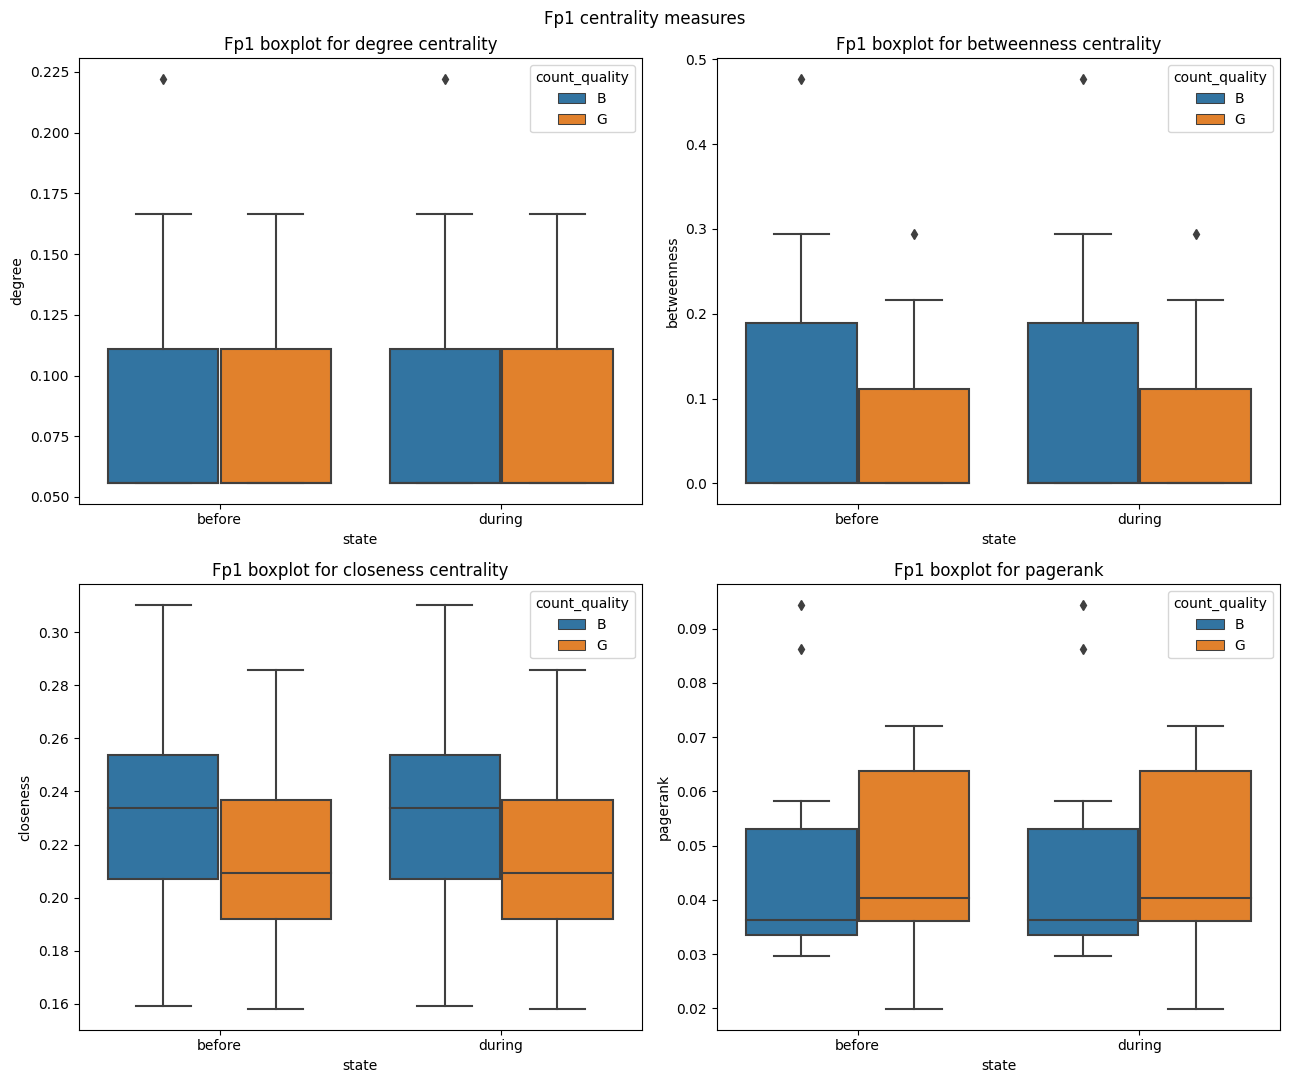

In [17]:
# Todas las gráficas de Fp1 para cada métrica diferente
sensor: str = 'Fp1'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

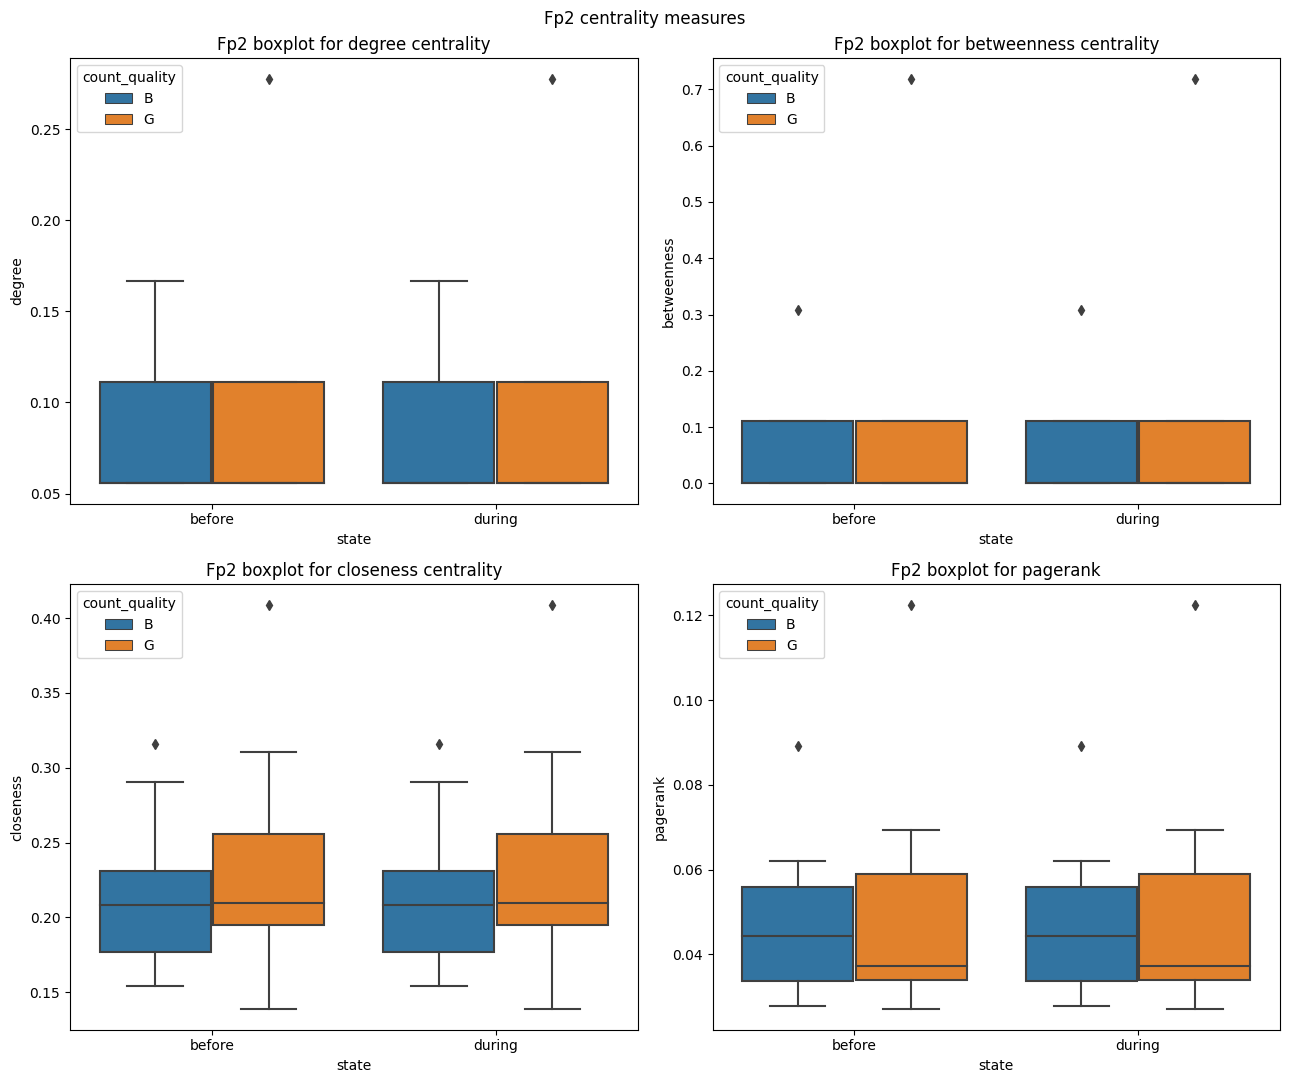

In [18]:
# Todas las gráficas de Fp2 para cada métrica diferente
sensor: str = 'Fp2'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

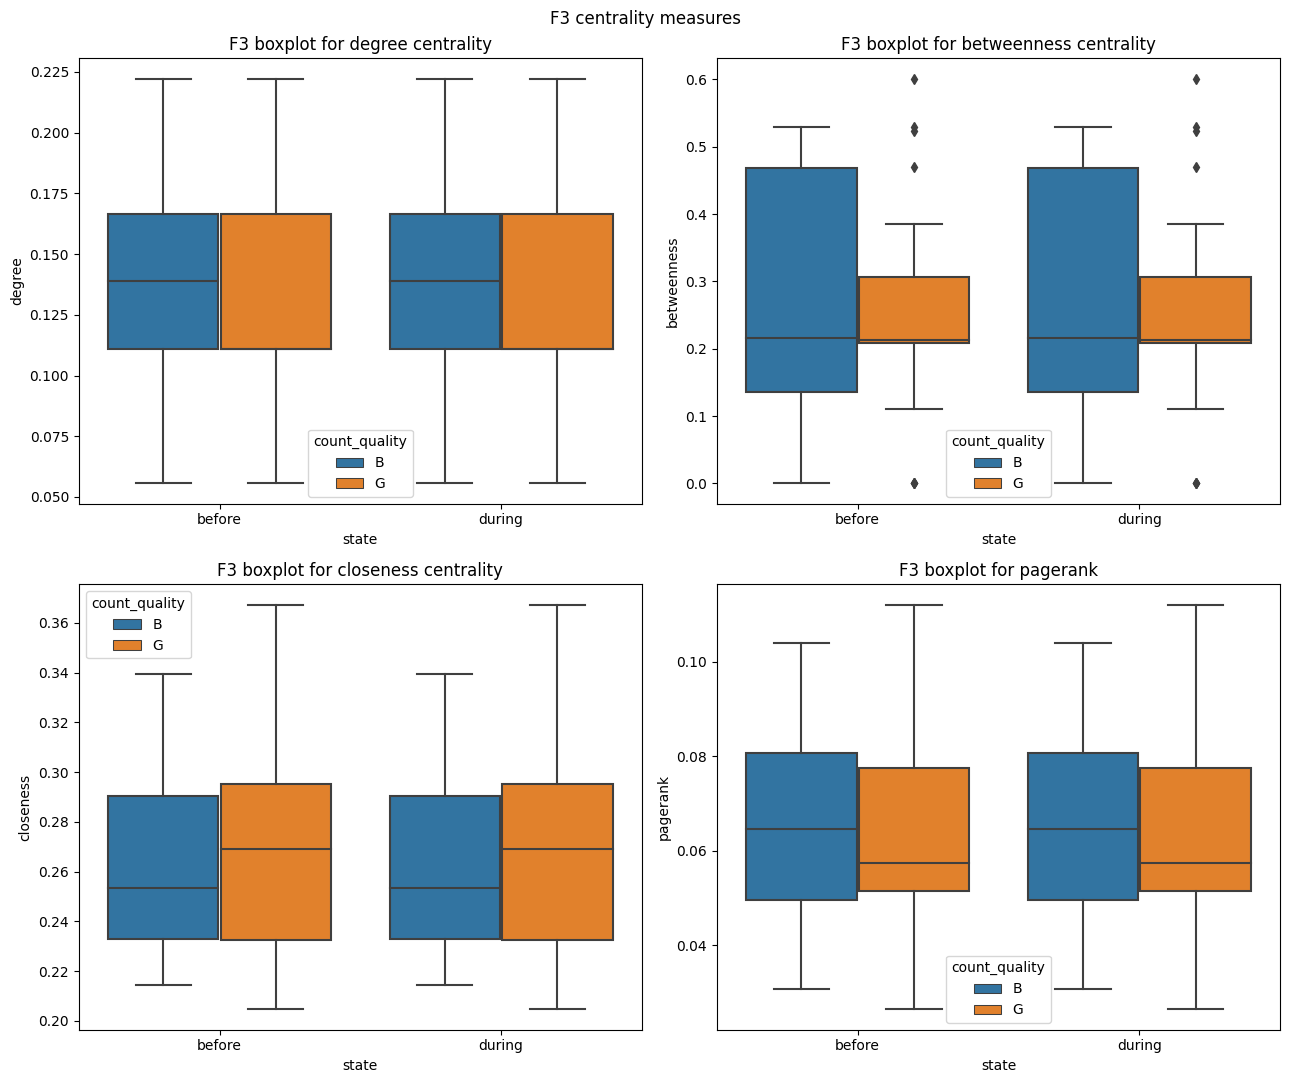

In [19]:
# Todas las gráficas de F3 para cada métrica diferente
sensor: str = 'F3'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

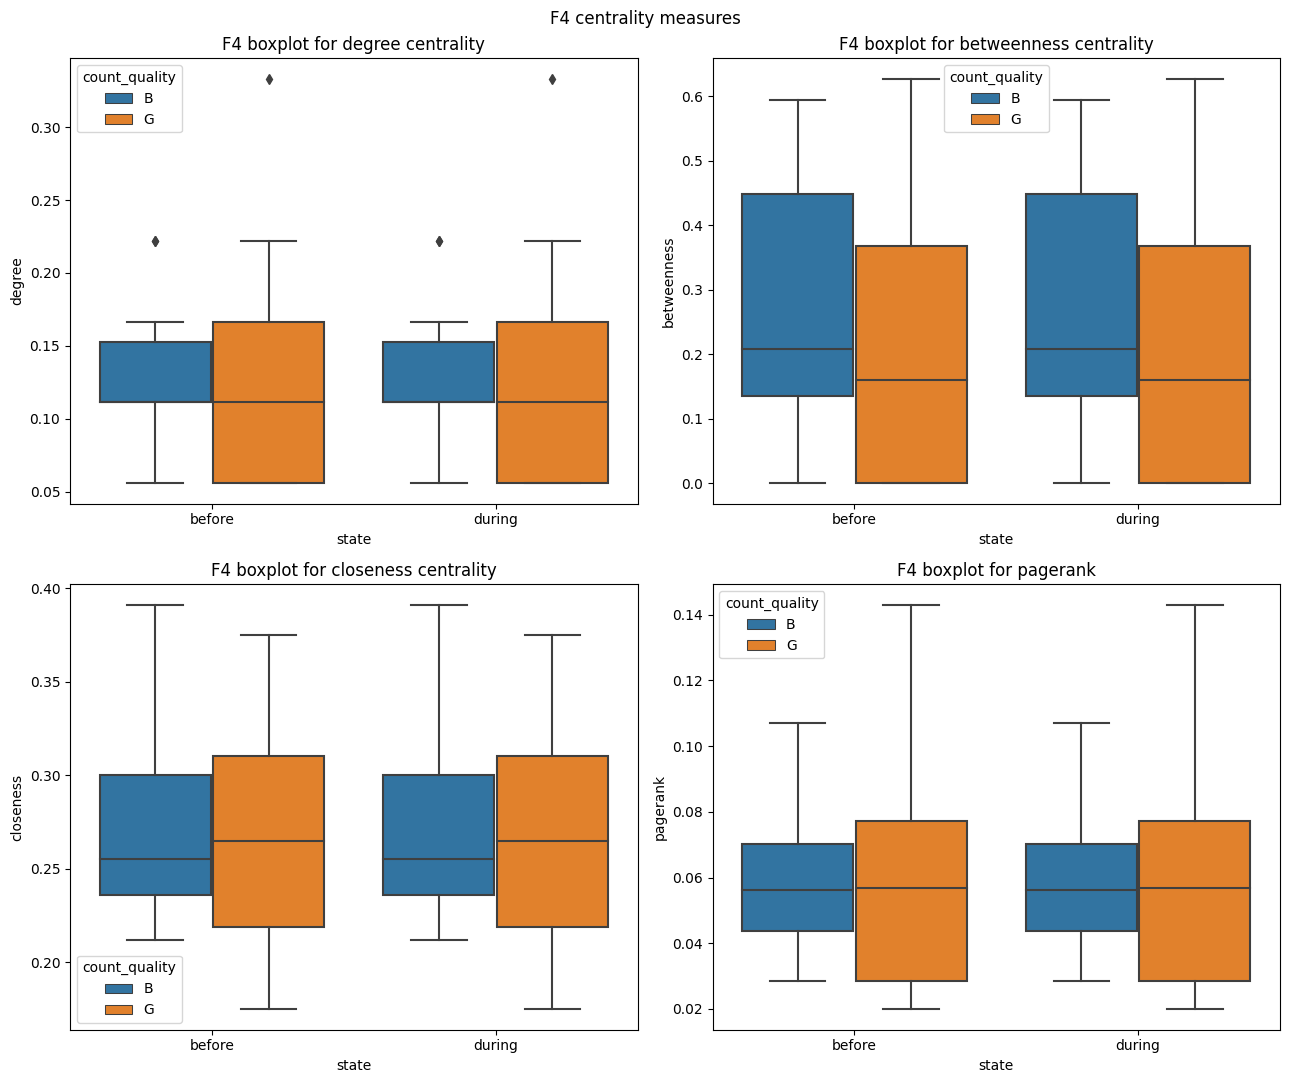

In [20]:
# Todas las gráficas de F4 para cada métrica diferente
sensor: str = 'F4'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

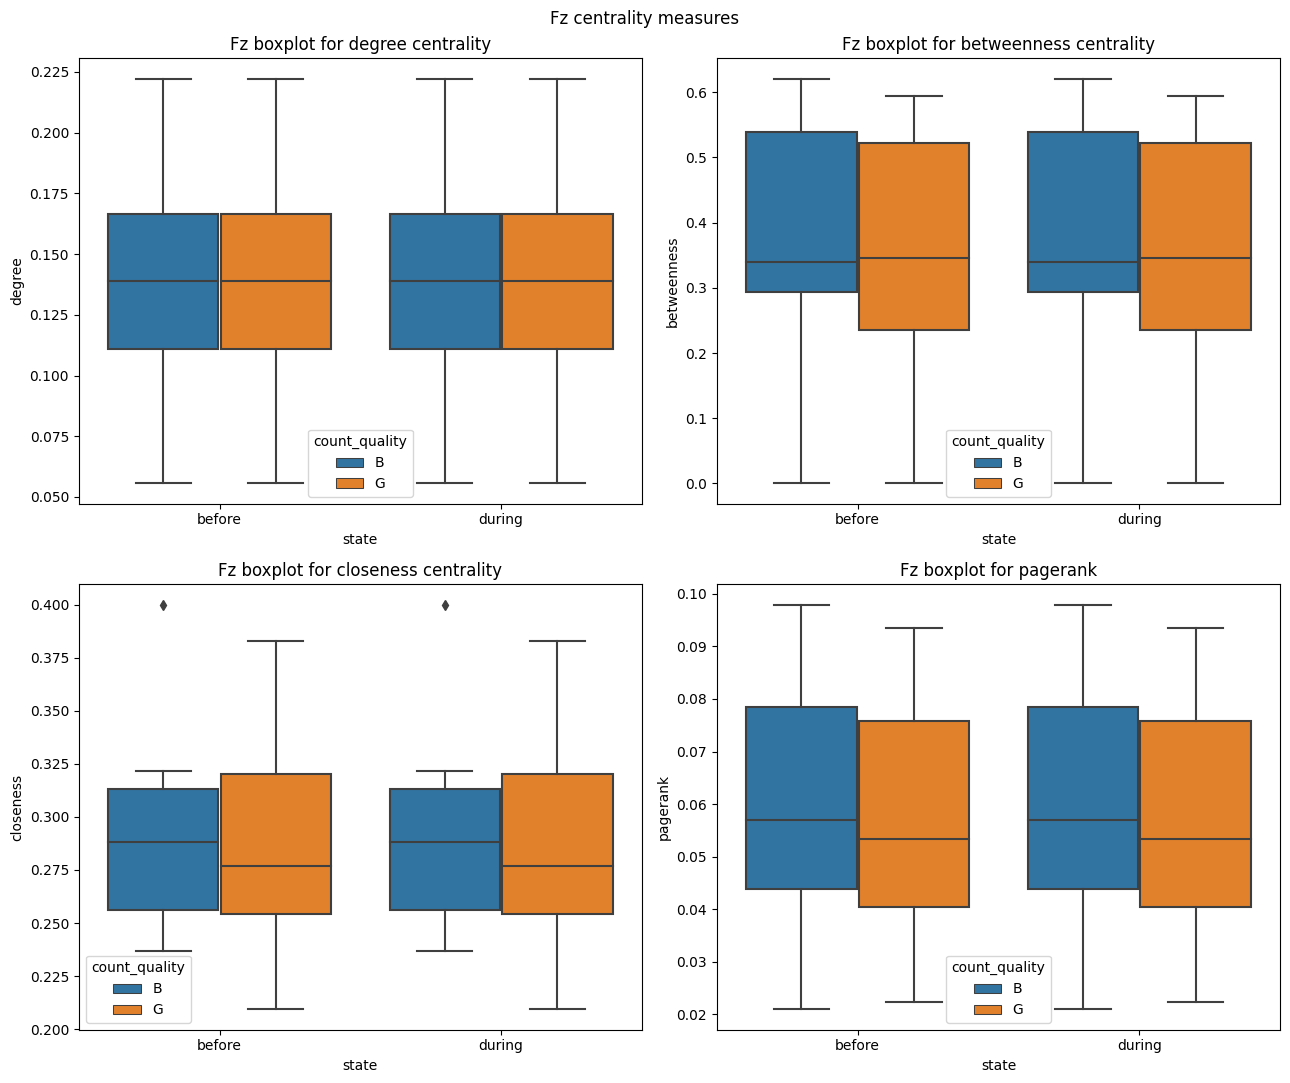

In [21]:
# Todas las gráficas de Fz para cada métrica diferente
sensor: str = 'Fz'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

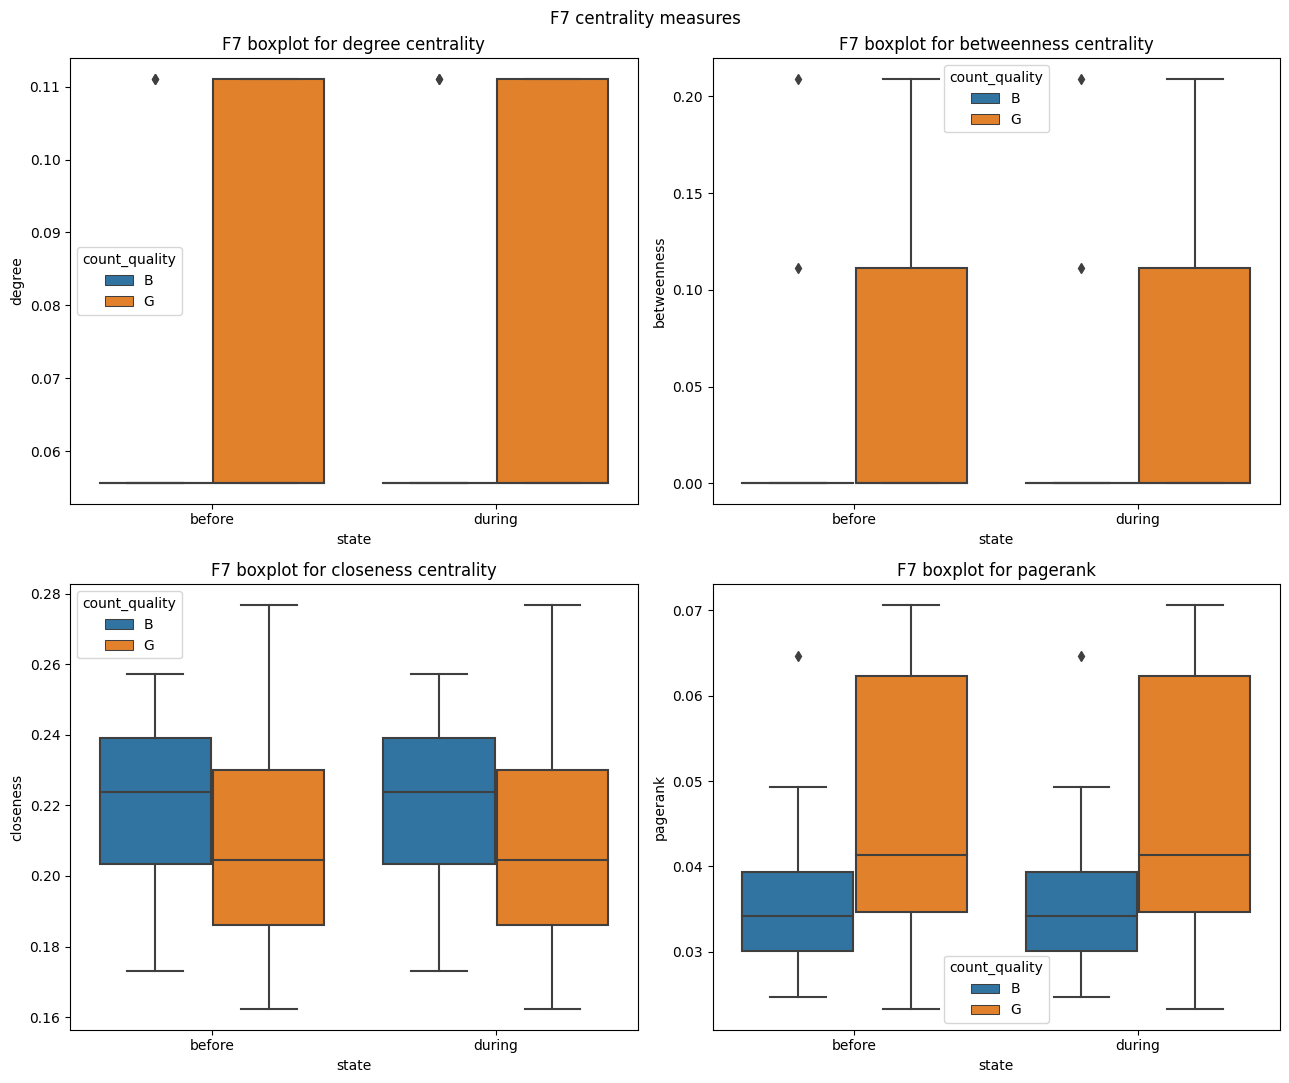

In [22]:
# Todas las gráficas de F7 para cada métrica diferente
sensor: str = 'F7'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

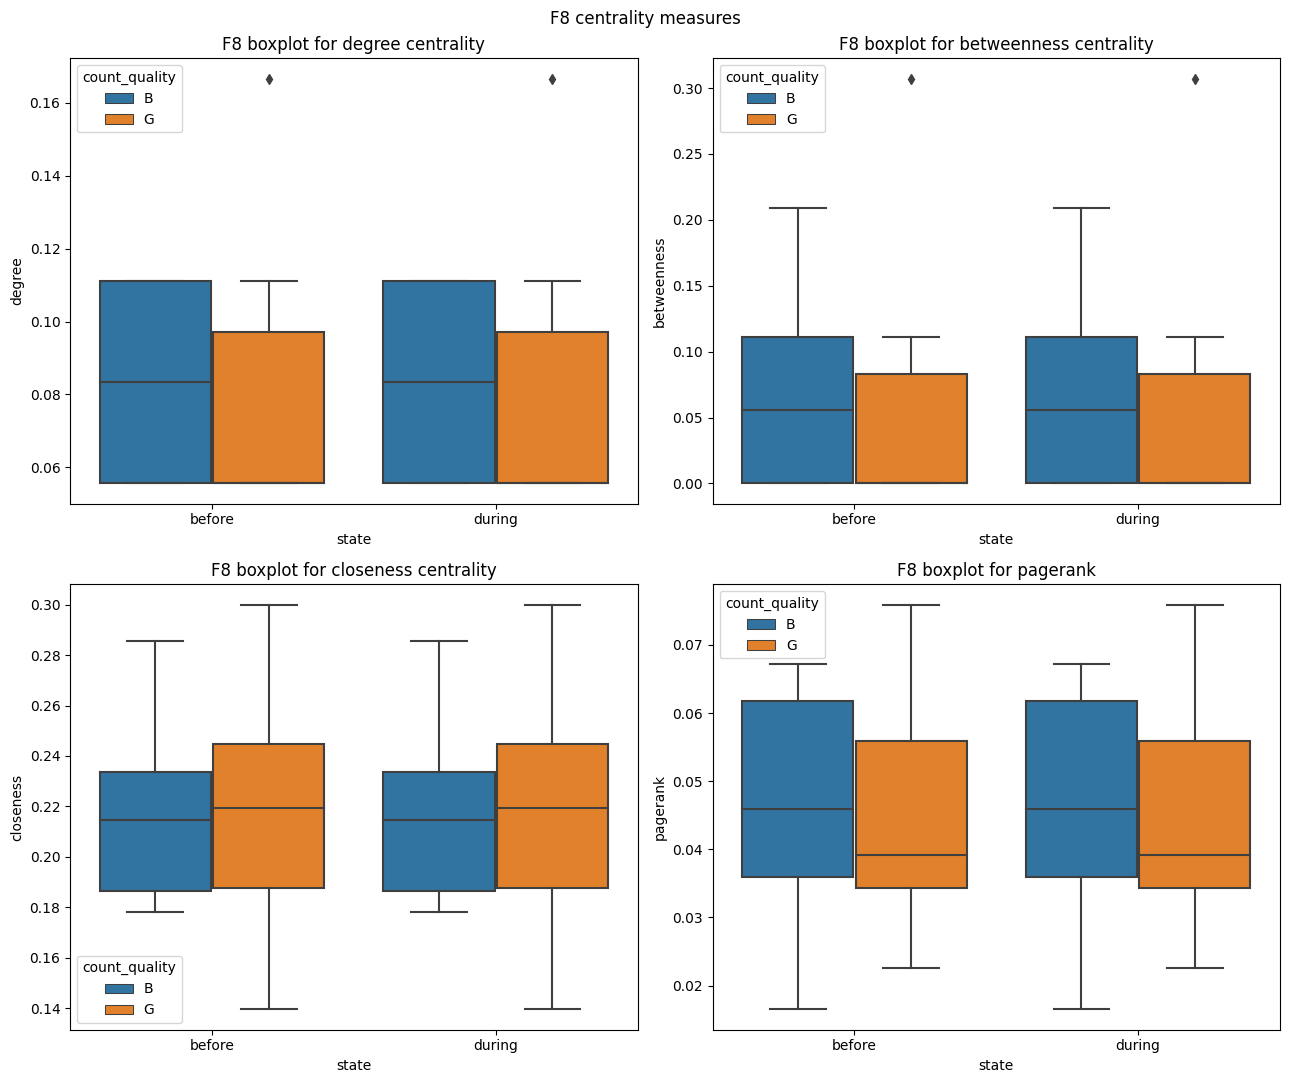

In [23]:
# Todas las gráficas de F8 para cada métrica diferente
sensor: str = 'F8'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

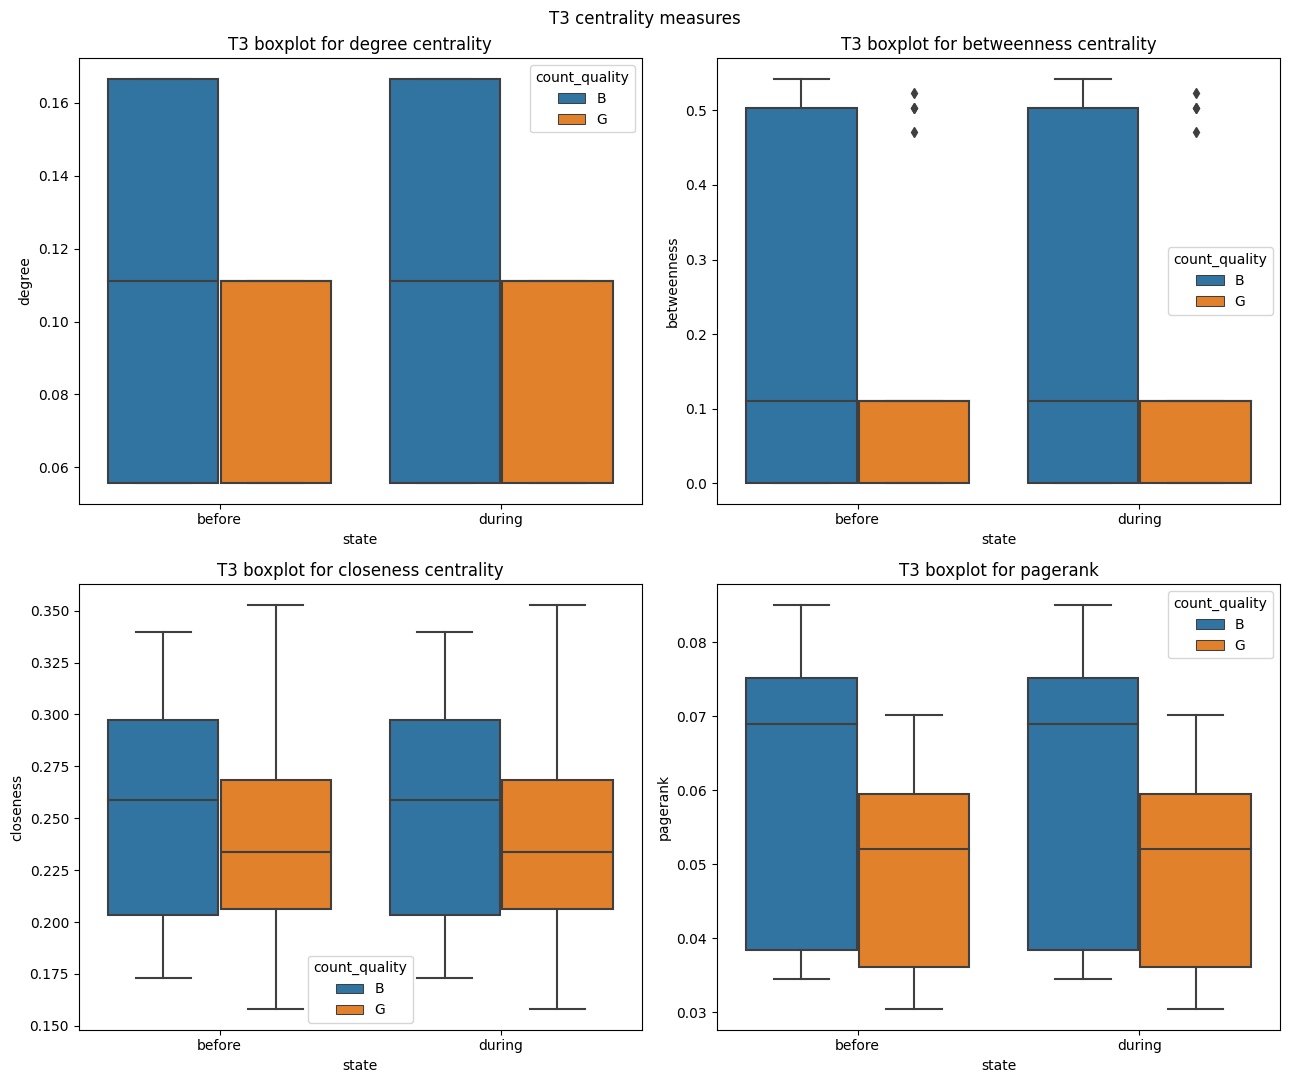

In [24]:
# Todas las gráficas de T3 para cada métrica diferente
sensor: str = 'T3'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

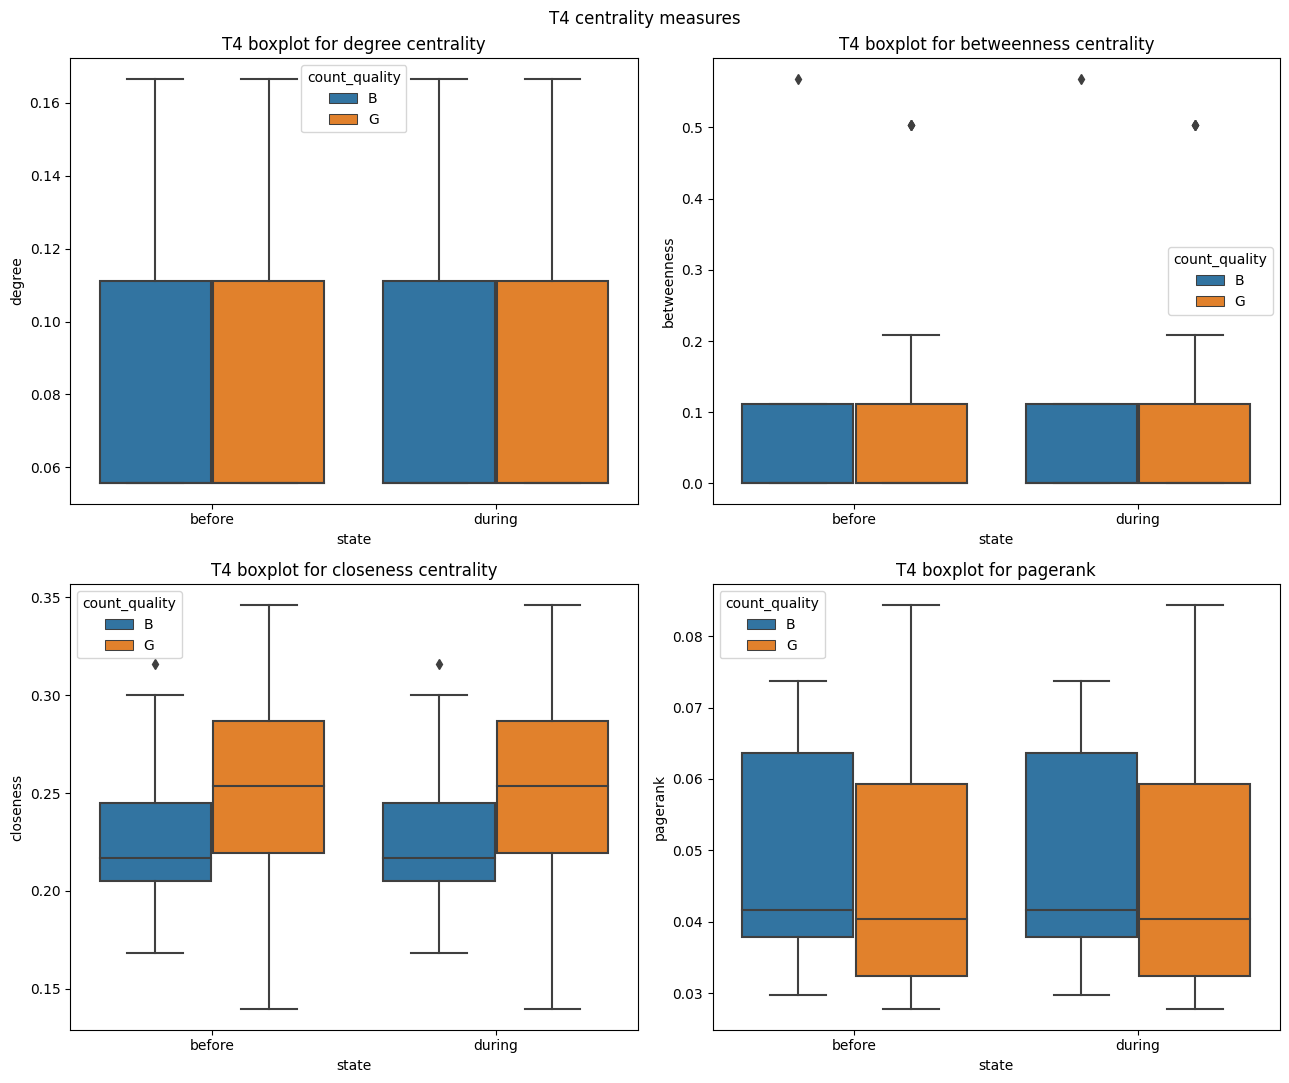

In [25]:
# Todas las gráficas de T4 para cada métrica diferente
sensor: str = 'T4'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

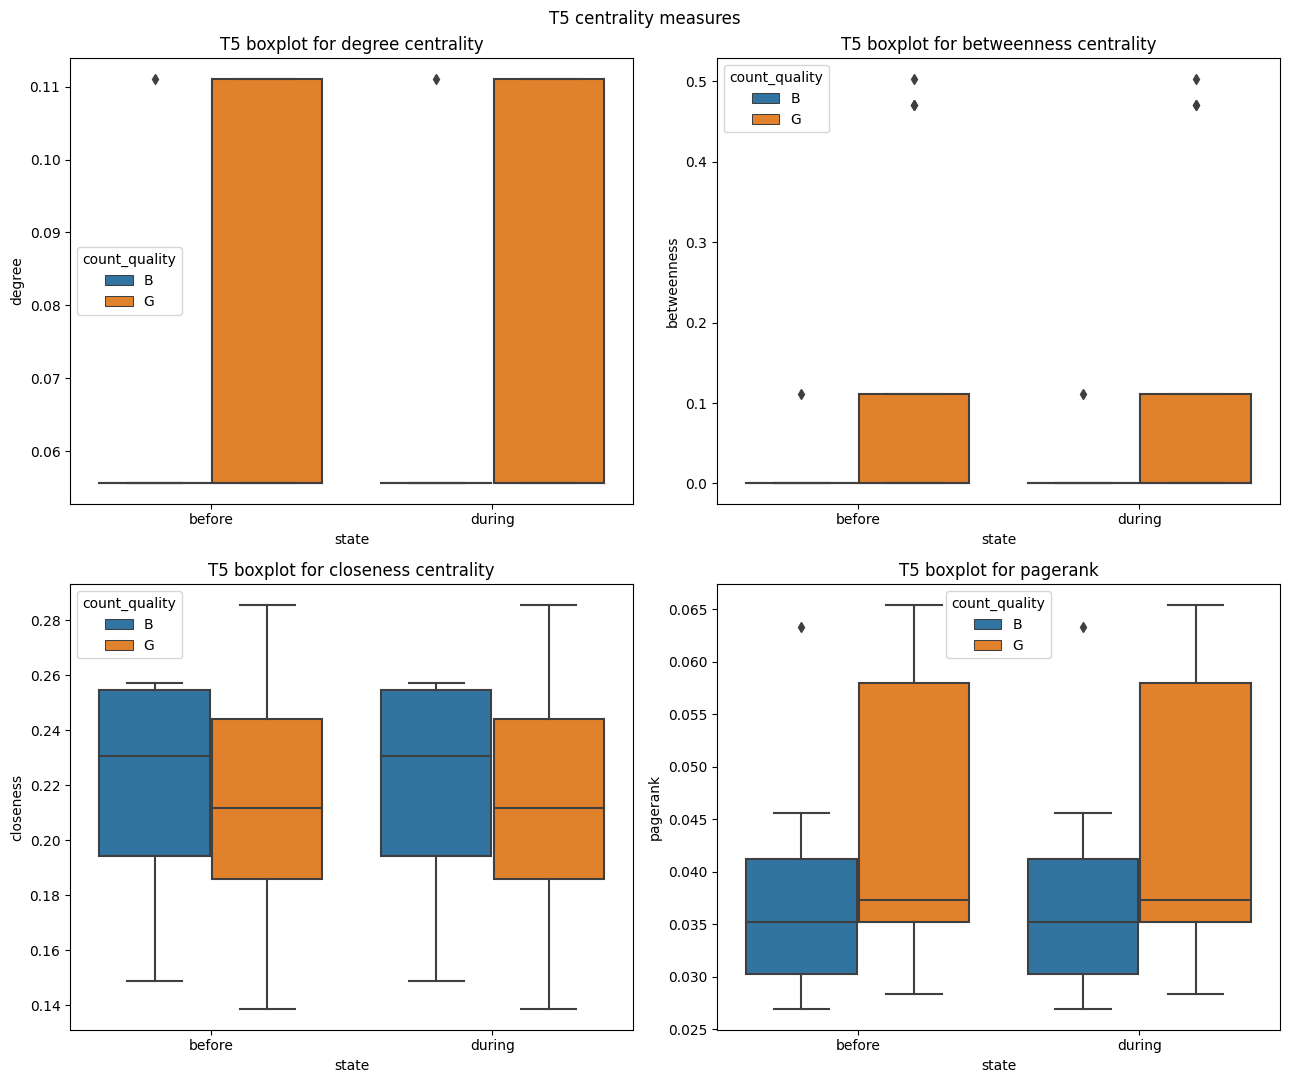

In [26]:
# Todas las gráficas de T5 para cada métrica diferente
sensor: str = 'T5'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

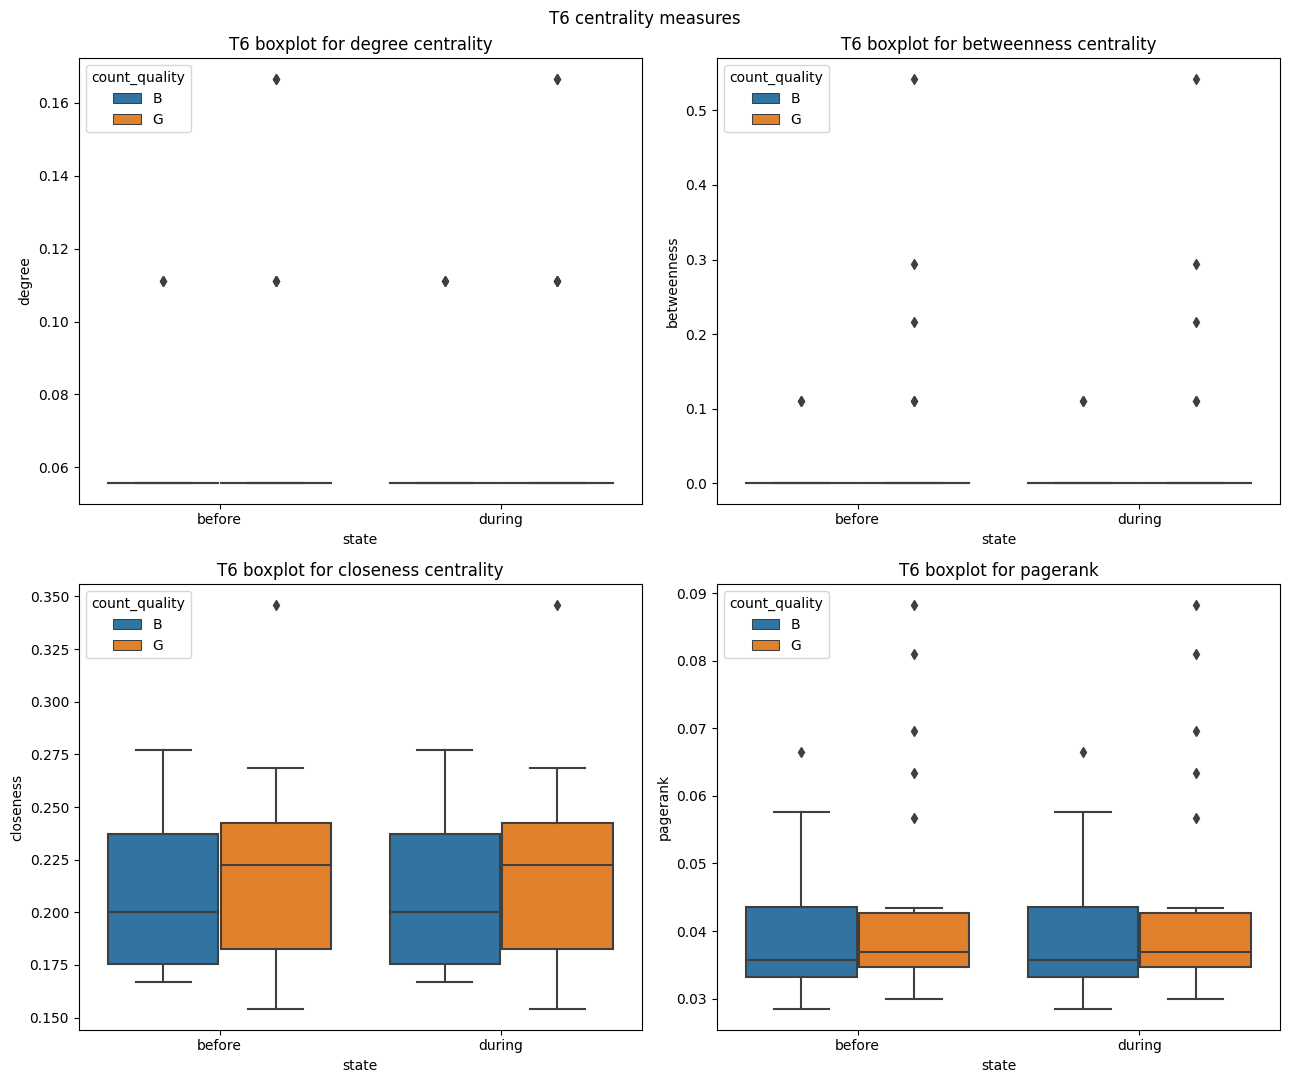

In [27]:
# Todas las gráficas de T6 para cada métrica diferente
sensor: str = 'T6'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

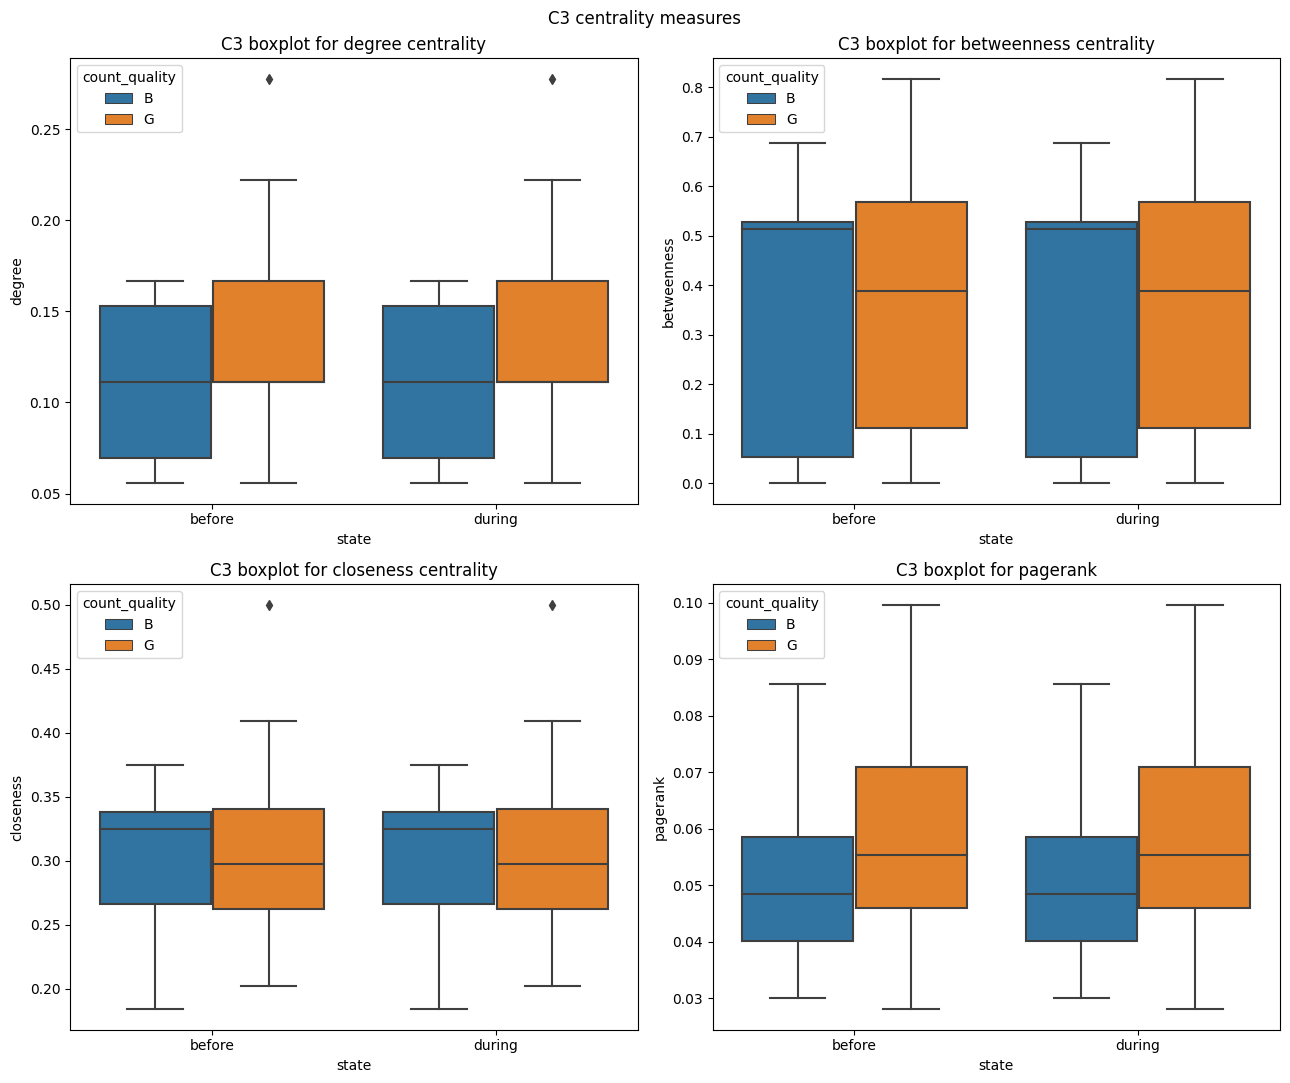

In [28]:
# Todas las gráficas de C3 para cada métrica diferente
sensor: str = 'C3'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

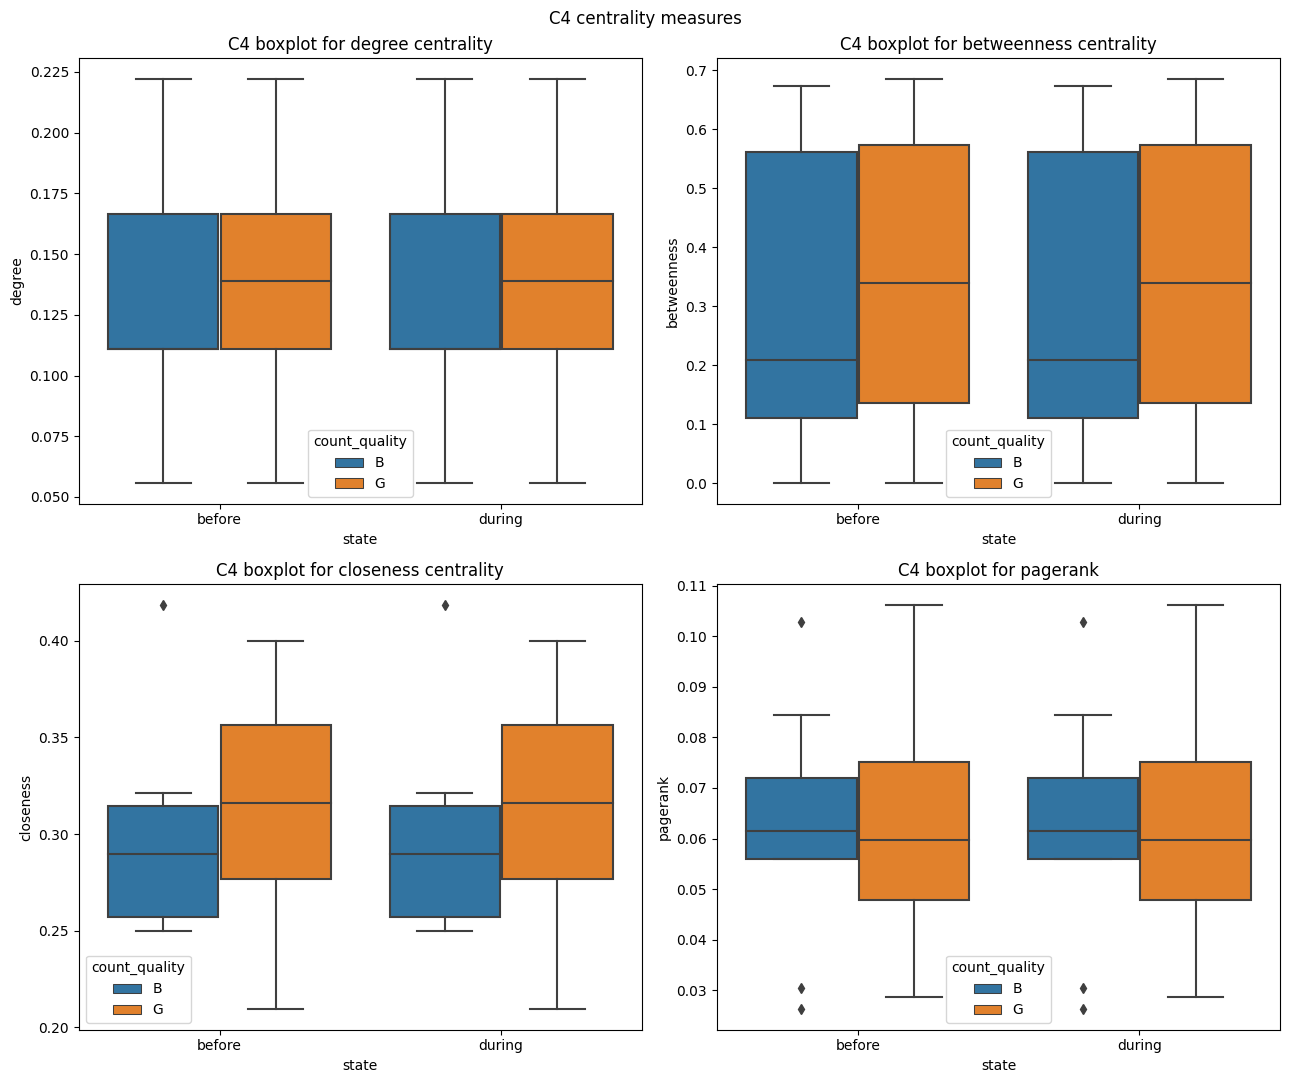

In [29]:
# Todas las gráficas de C4 para cada métrica diferente
sensor: str = 'C4'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

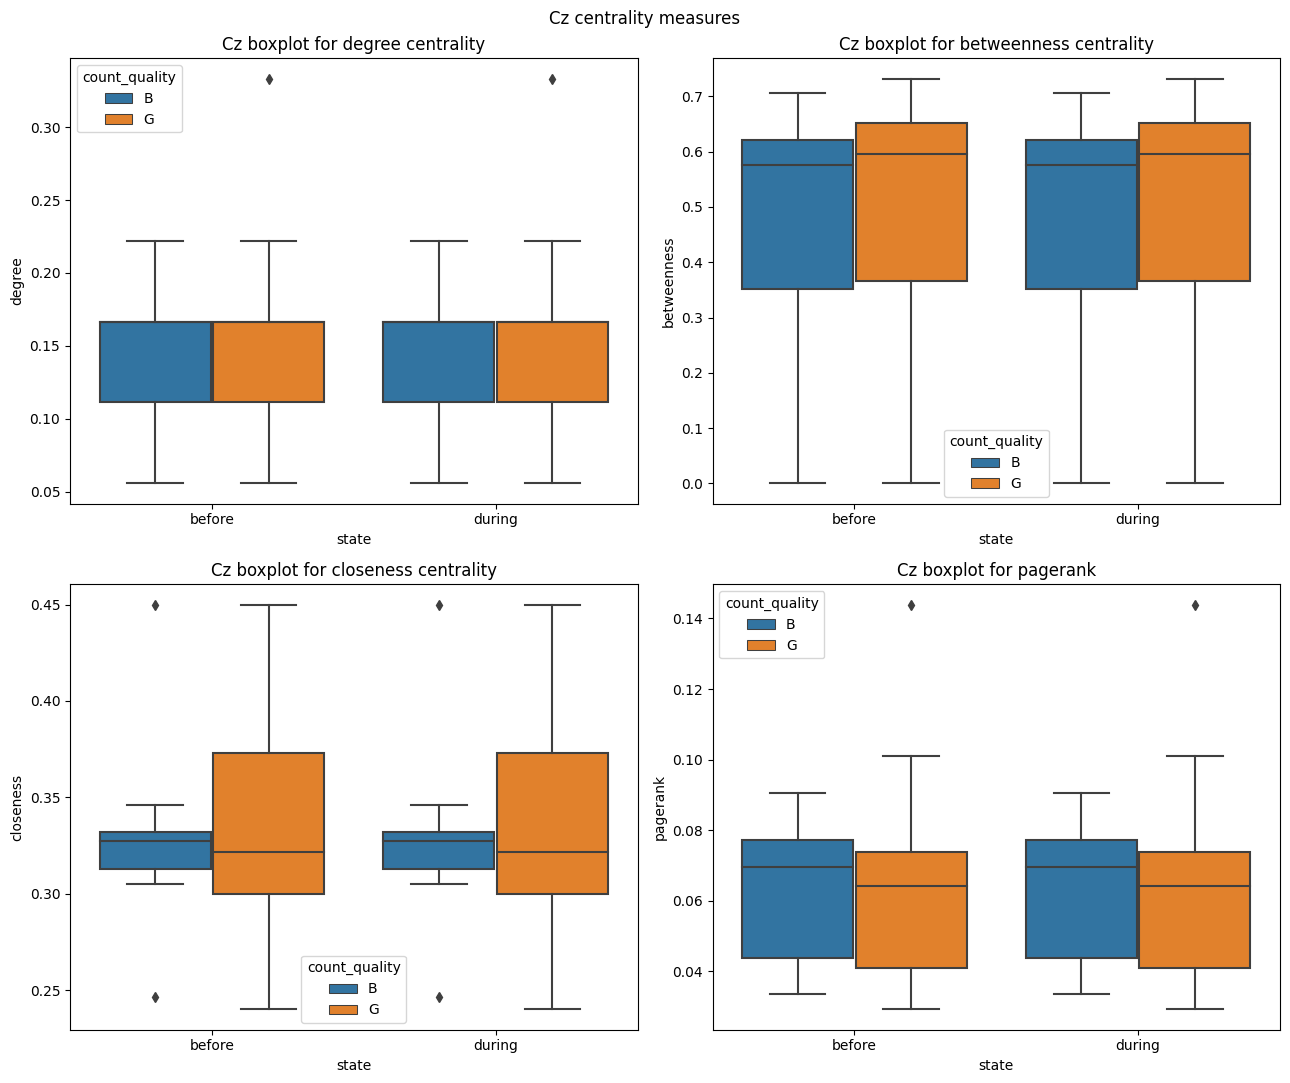

In [30]:
# Todas las gráficas de Cz para cada métrica diferente
sensor: str = 'Cz'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

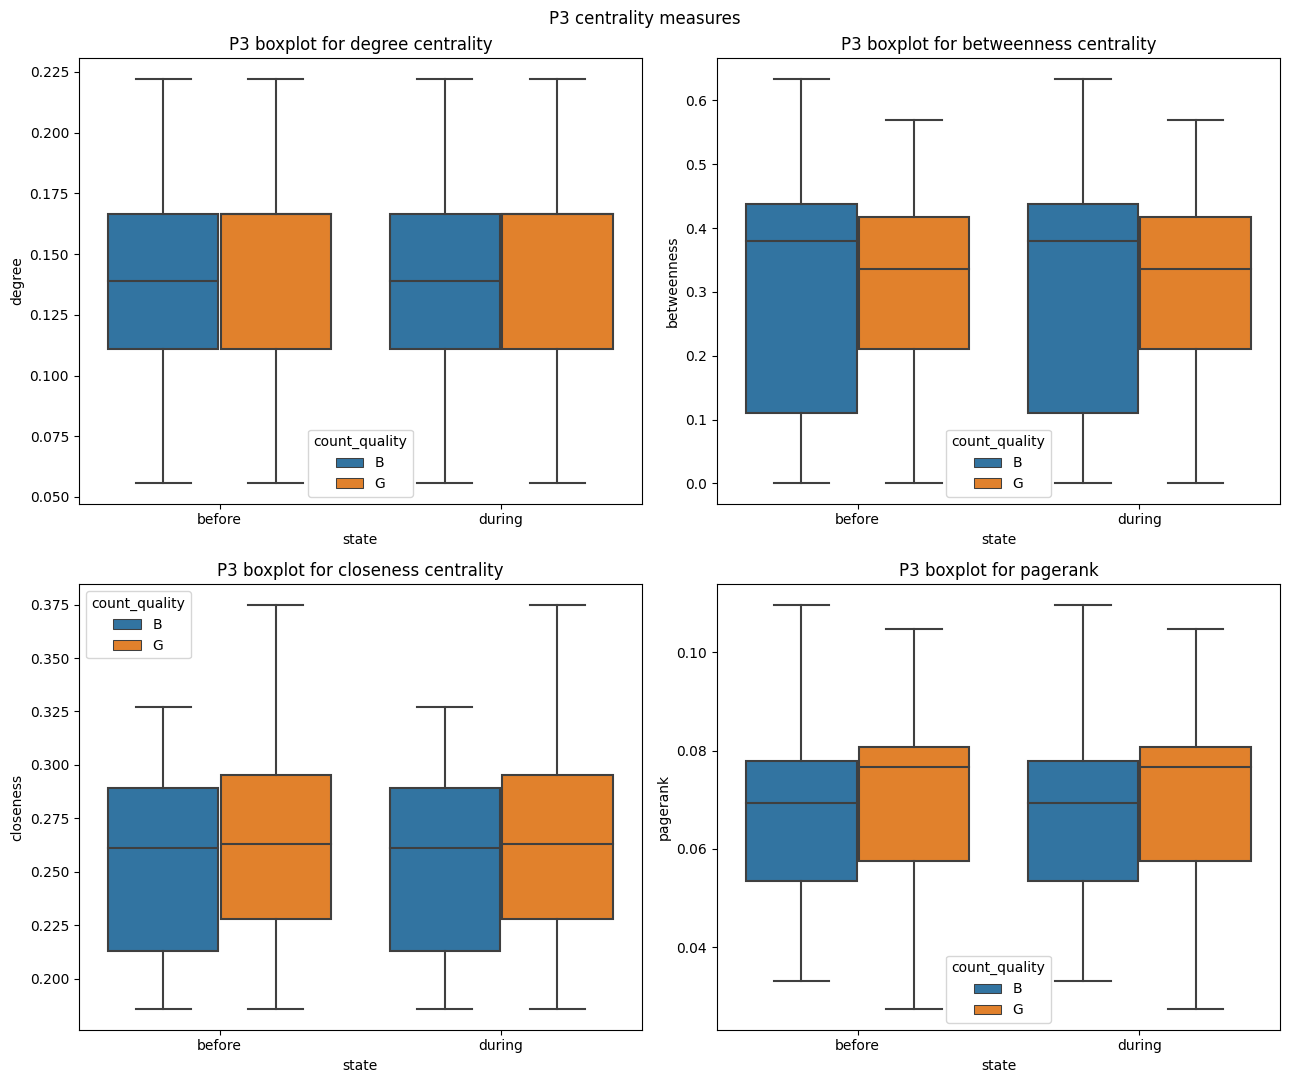

In [31]:
# Todas las gráficas de P3 para cada métrica diferente
sensor: str = 'P3'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

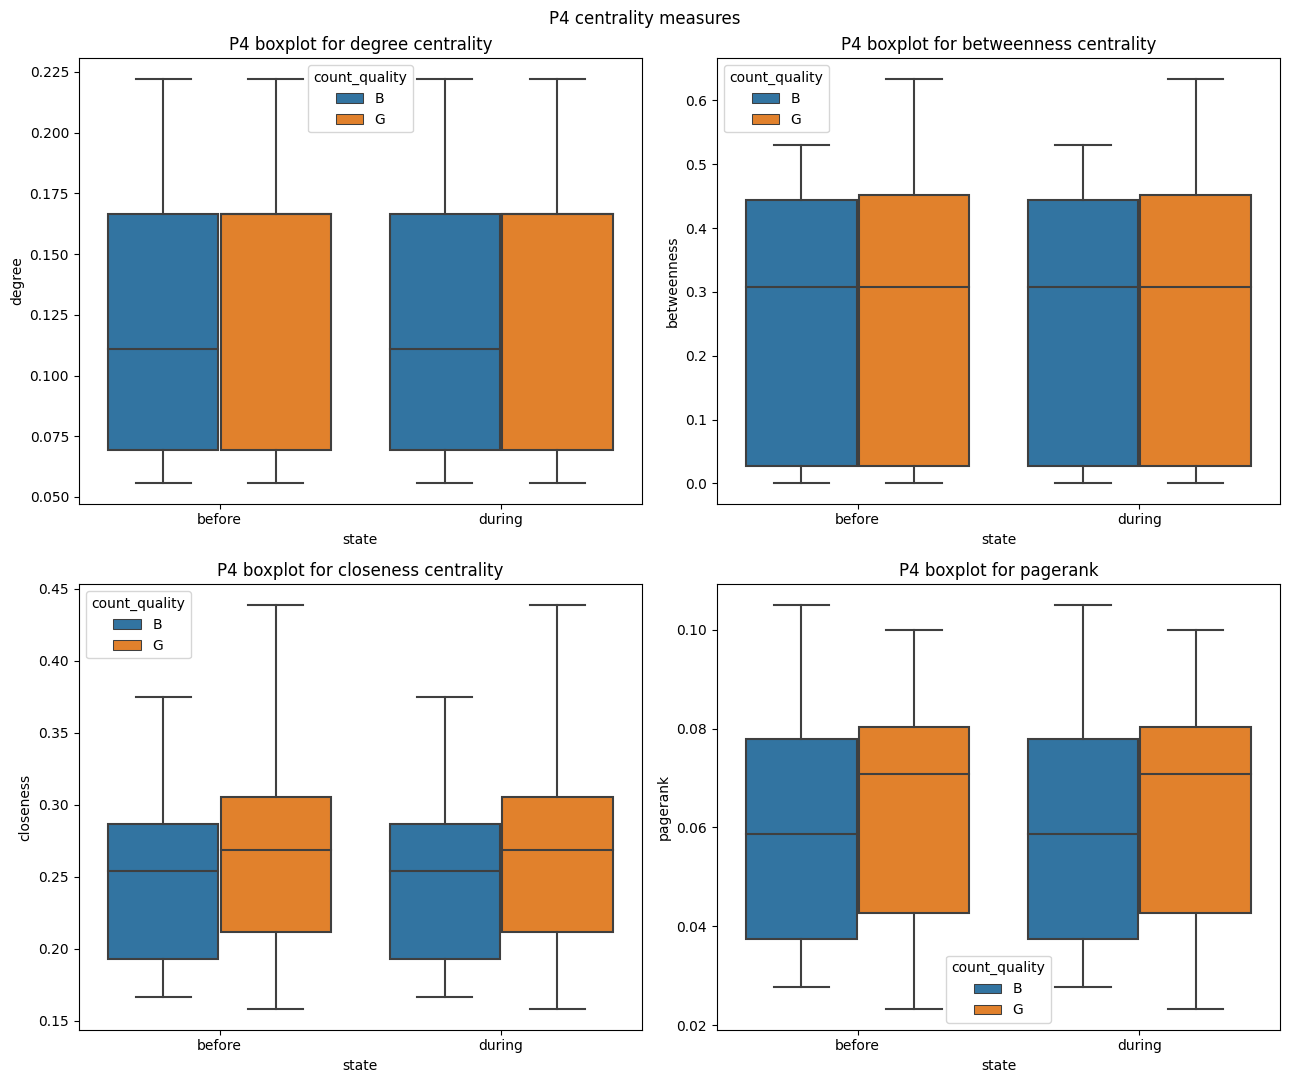

In [32]:
# Todas las gráficas de P4 para cada métrica diferente
sensor: str = 'P4'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

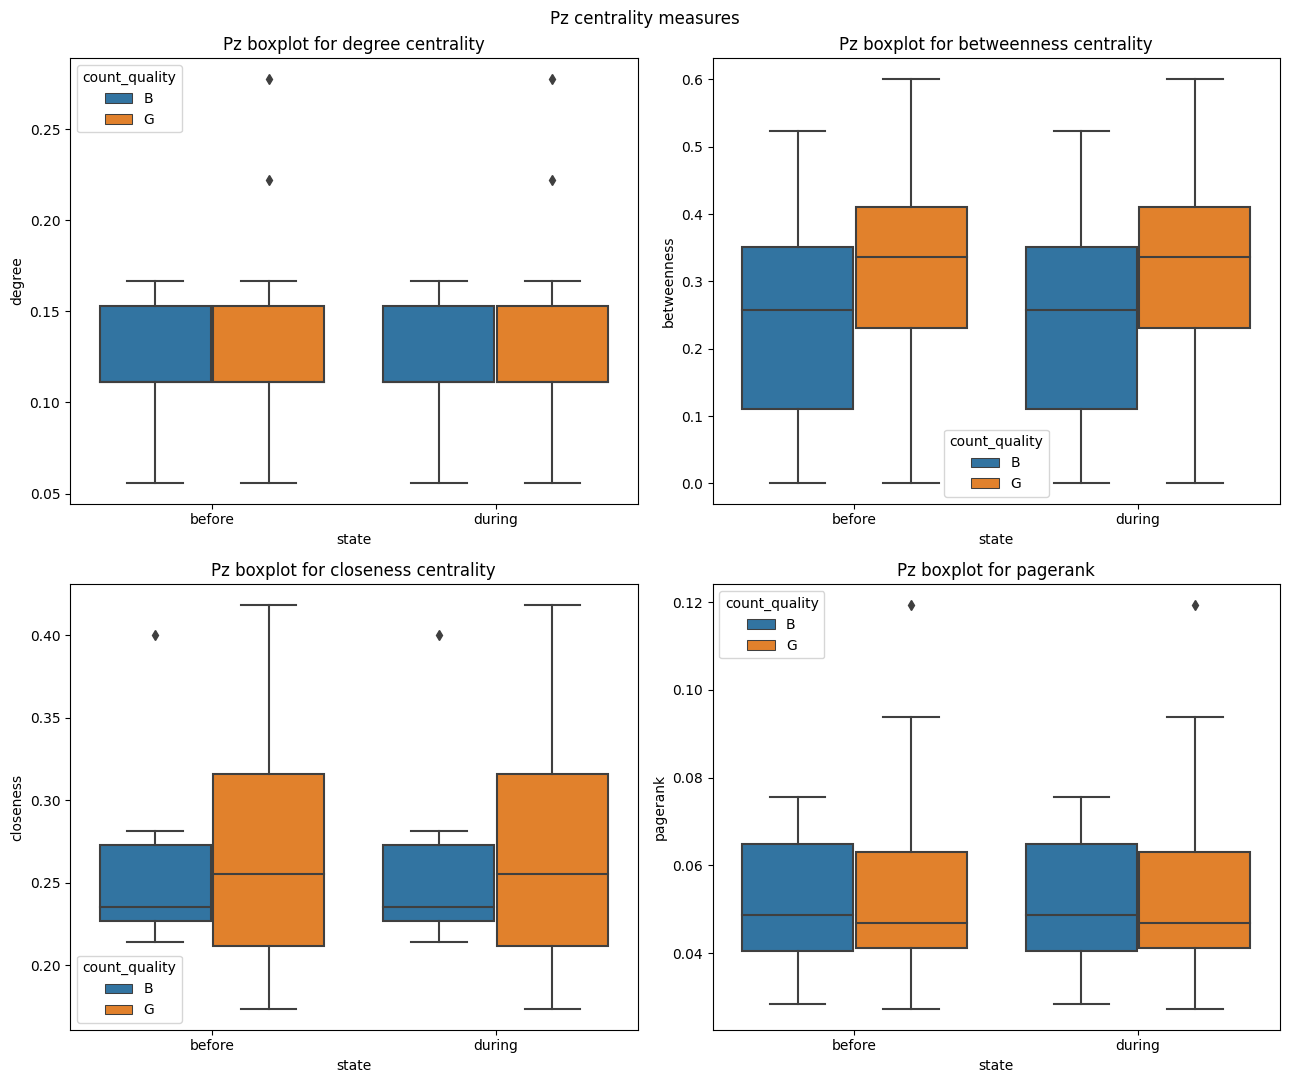

In [33]:
# Todas las gráficas de Pz para cada métrica diferente
sensor: str = 'Pz'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

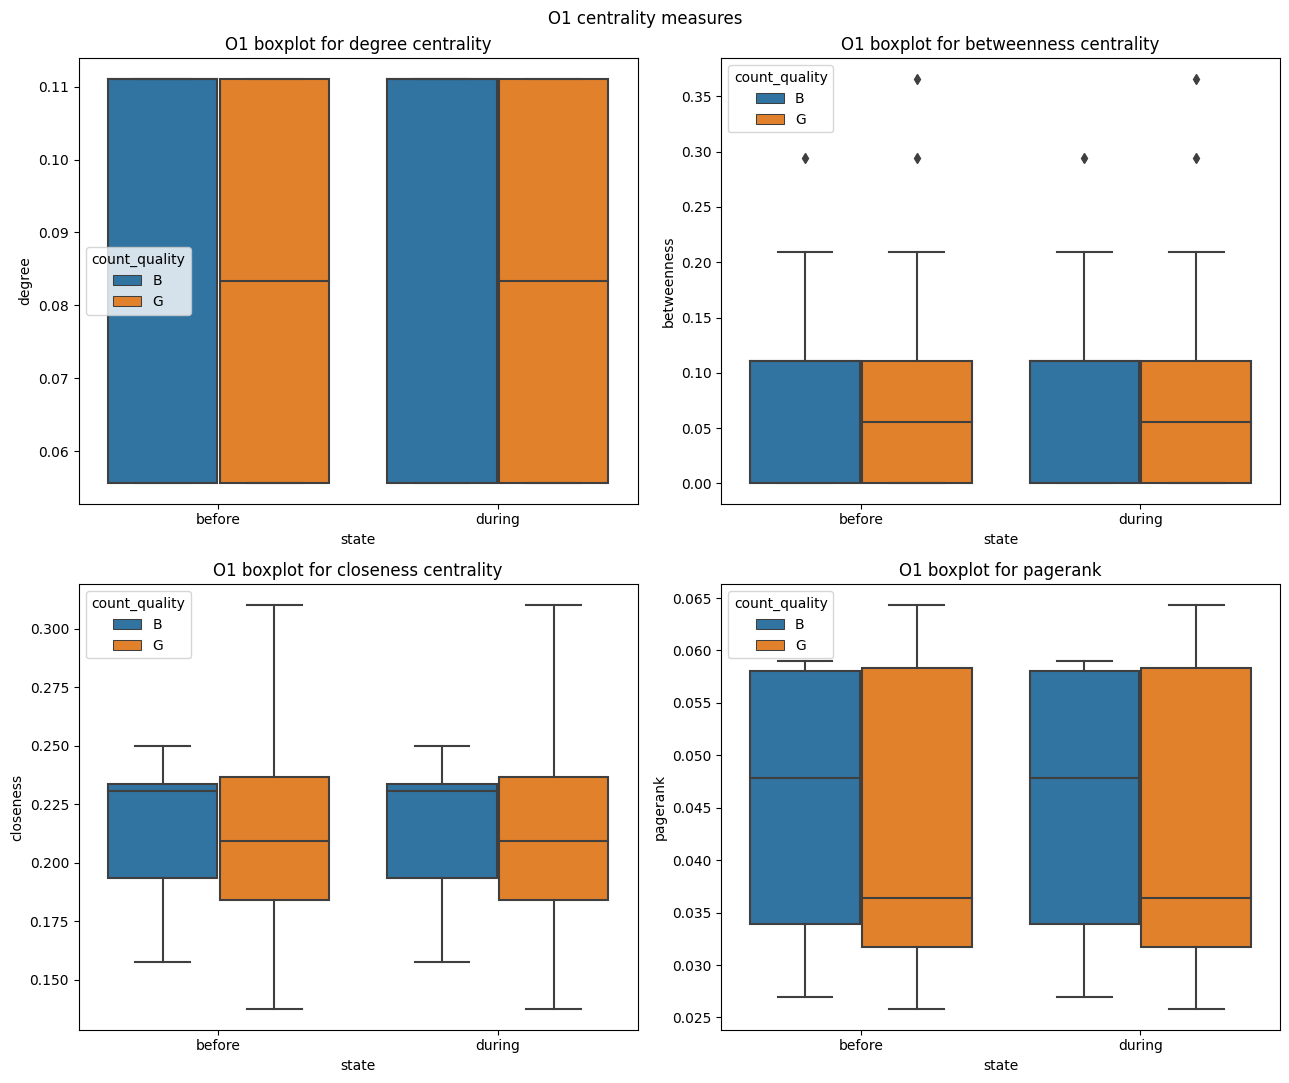

In [34]:
# Todas las gráficas de O1 para cada métrica diferente
sensor: str = 'O1'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

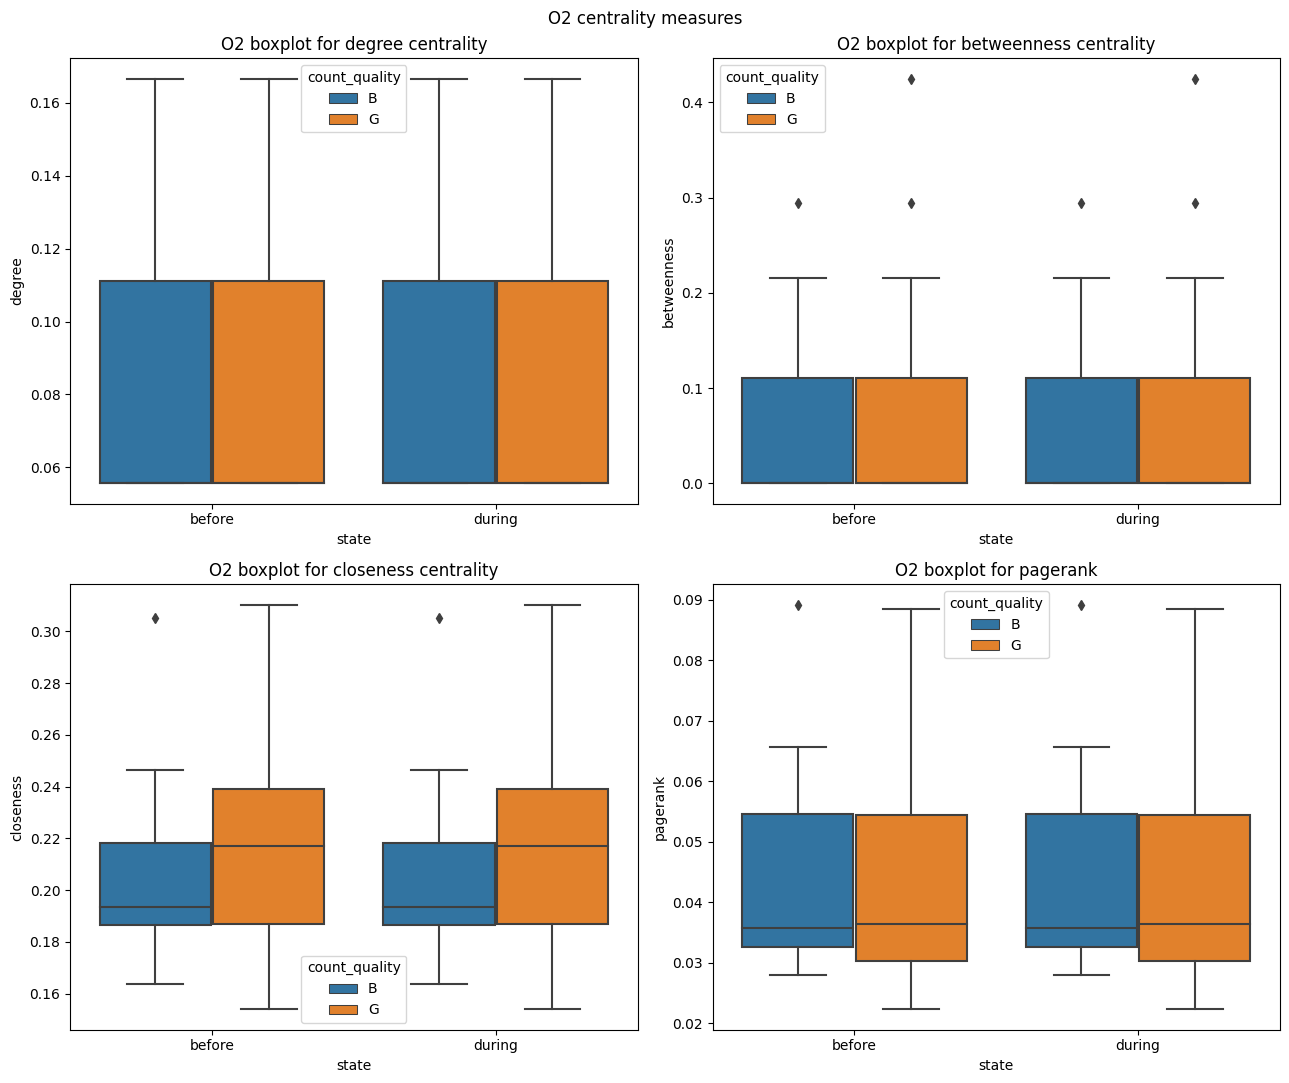

In [35]:
# Todas las gráficas de O2 para cada métrica diferente
sensor: str = 'O2'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

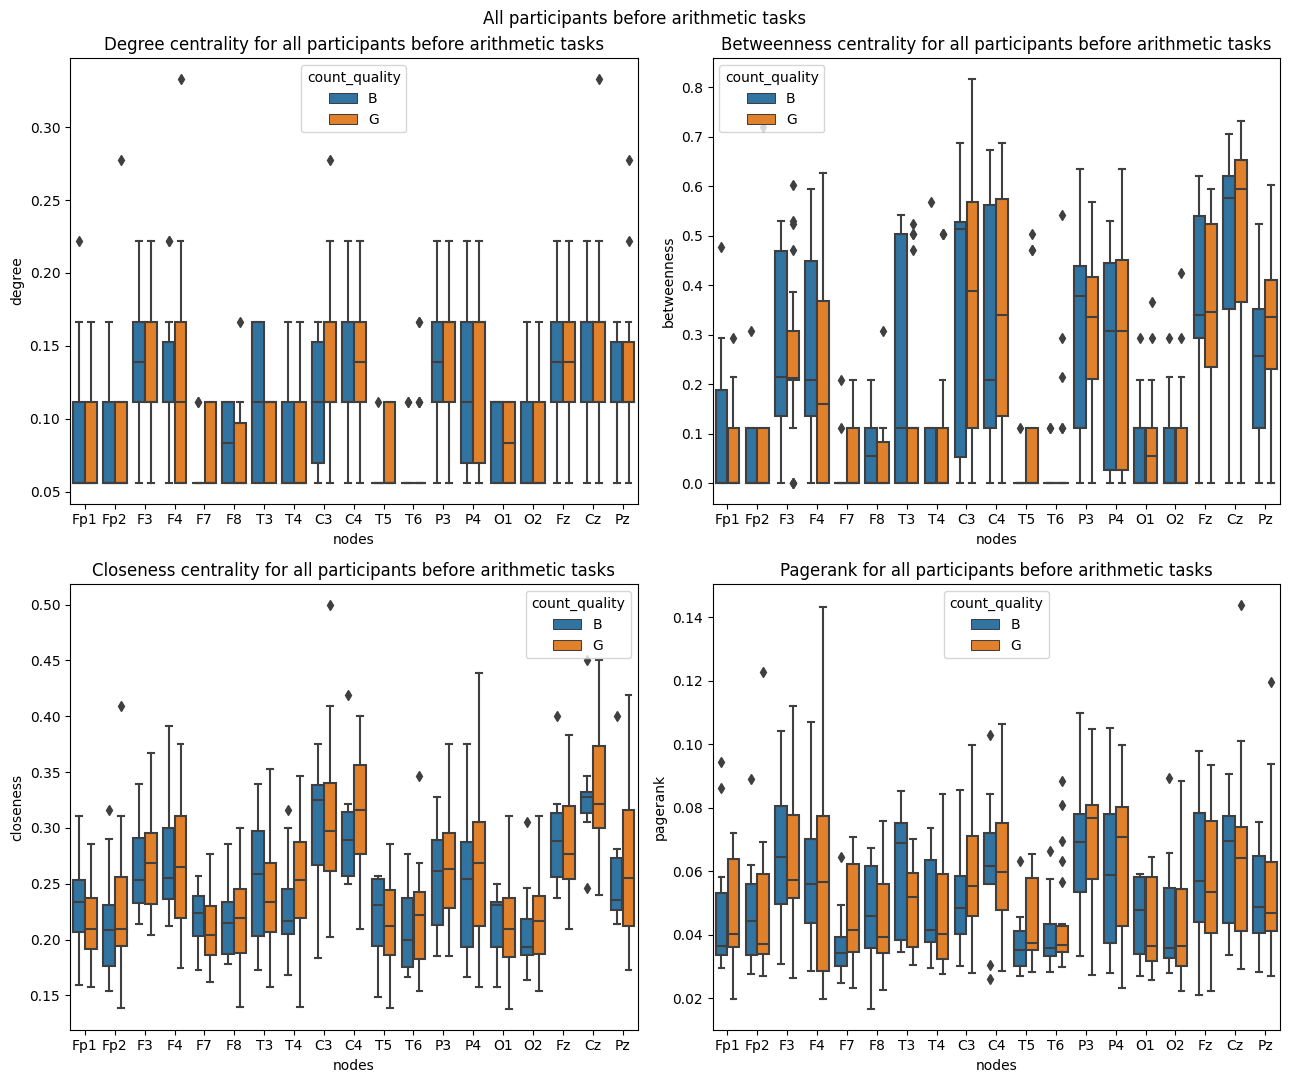

In [36]:
# Todos los nodos de los participantes antes

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('All participants before arithmetic tasks')

ax1.set_title('Degree centrality for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title('Betweenness centrality for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title('Closeness centrality for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title('Pagerank for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

In [37]:
# Todos los nodos de los participantes durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('All participants during arithmetic tasks')

ax1.set_title('Degree centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title('Betweenness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title('Closeness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title('Pagerank for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

In [ ]:
# Obtener el promedio de la matriz de distancias
n = 35 + 1

ave_before = np.zeros((19, 19))
ave_during = np.zeros((19, 19))

for i in range(n):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    ave_before += get_distances(csv_path1)
    ave_during += get_distances(csv_path2)

ave_before /= n
ave_during /= n


df_centrality_ave_bef = get_centrality_from_df(ave_before)
df_centrality_ave_dur = get_centrality_from_df(ave_during)

df_centrality_ave_bef.to_csv('Archivos\\ave_centrality_before.csv', sep=';', index=False)
df_centrality_ave_dur.to_csv('Archivos\\ave_centrality_during.csv', sep=';', index=False)

In [ ]:
df_centrality_ave_bef = pd.read_csv('Archivos\\ave_centrality_before.csv', delimiter=';')
df_centrality_ave_bef['status'] = 'before'

df_centrality_ave_dur = pd.read_csv('Archivos\\ave_centrality_before.csv', delimiter=';')
df_centrality_ave_dur['status'] = 'during'

df_centrality_ave = pd.concat([df_centrality_ave_bef, df_centrality_ave_dur], ignore_index=True)

display(df_centrality_ave)

In [ ]:
# Todos los nodos de los participantes durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Average participants')

ax1.set_title('Degree centrality')
sns.barplot(
    df_centrality_ave, x='nodes', y='degree', hue='status', ax=ax1
)

ax2.set_title('Betweenness centrality')
sns.barplot(
    df_centrality_ave, x='nodes', y='betweenness', hue='status', ax=ax2
)

ax3.set_title('Closeness centrality')
sns.barplot(
    df_centrality_ave, x='nodes', y='closeness', hue='status', ax=ax3
)

ax4.set_title('Pagerank')
sns.barplot(
    df_centrality_ave, x='nodes', y='pagerank', hue='status', ax=ax4
)

plt.tight_layout()

In [ ]:
mst_g_ave_before = get_mst_from_df(ave_before)
mst_g_ave_during = get_mst_from_df(ave_during)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 7))
fig.suptitle('Average distances')

ax1.set_title('Before')
nx.draw_networkx(
    mst_g_ave_before,
    nx.planar_layout(mst_g_ave_before),
    ax = ax1
)

ax2.set_title('During')
nx.draw_networkx(
    mst_g_ave_during,
    nx.planar_layout(mst_g_ave_during),
    ax = ax2
)

In [31]:
# Promedio de las personas dependiendo de su calidad de conteo (antes y durante)

ave_b_before, ave_g_before = np.zeros((19, 19)), np.zeros((19, 19))
ave_b_during, ave_g_during = np.zeros((19, 19)), np.zeros((19, 19))
n_b, n_g = 0, 0

for i in range(35 + 1):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    if df_subject_info['Count quality'][i] == 1:
        ave_g_before += get_distances(csv_path1)
        ave_g_during += get_distances(csv_path2)
        n_g += 1
    else:
        ave_b_before += get_distances(csv_path1)
        ave_b_during += get_distances(csv_path2)
        n_b += 1

ave_g_before /= n_g
ave_g_during /= n_g
ave_b_before /= n_b
ave_b_during /= n_b

df_centrality_ave_g_before = get_centrality_from_df(ave_g_before)
df_centrality_ave_g_during = get_centrality_from_df(ave_g_during)
df_centrality_ave_b_before = get_centrality_from_df(ave_b_before)
df_centrality_ave_b_during = get_centrality_from_df(ave_b_during)

df_centrality_ave_g_before['status'] = 'before'
df_centrality_ave_g_during['status'] = 'during'
df_centrality_ave_b_before['status'] = 'before'
df_centrality_ave_b_during['status'] = 'during'

df_centrality_ave_g = pd.concat([df_centrality_ave_g_before, df_centrality_ave_g_during], ignore_index=True)
df_centrality_ave_b = pd.concat([df_centrality_ave_b_before, df_centrality_ave_b_during], ignore_index=True)

df_centrality_ave_g.to_csv('Archivos\\ave_centrality_good.csv', sep=';', index=False)
df_centrality_ave_b.to_csv('Archivos\\ave_centrality_bad.csv', sep=';', index=False)

In [ ]:
df_centrality_ave_g = pd.read_csv('Archivos\\ave_centrality_good.csv', delimiter=';')
df_centrality_ave_b = pd.read_csv('Archivos\\ave_centrality_bad.csv', delimiter=';')

df_centrality_ave_g['Count quality'] = 'G'
df_centrality_ave_b['Count quality'] = 'B'

df_centrality_ave_counts = pd.concat([df_centrality_ave_b, df_centrality_ave_g], ignore_index=True)

df_centrality_ave_counts

,nodes,degree,betweenness,closeness,pagerank,status,Count quality
0,Fp1,0.111111,0.111111,0.216867,0.061987,before,B
1,Fp2,0.055556,0.000000,0.180000,0.035518,before,B
2,F3,0.111111,0.209150,0.264706,0.049925,before,B
3,F4,0.111111,0.209150,0.264706,0.050579,before,B
4,F7,0.055556,0.000000,0.180000,0.035466,before,B
...,...,...,...,...,...,...,...
71,O1,0.055556,0.000000,0.165138,0.032681,during,G
72,O2,0.111111,0.111111,0.195652,0.058685,during,G
73,Fz,0.166667,0.529412,0.321429,0.061987,during,G
74,Cz,0.166667,0.620915,0.352941,0.063293,during,G


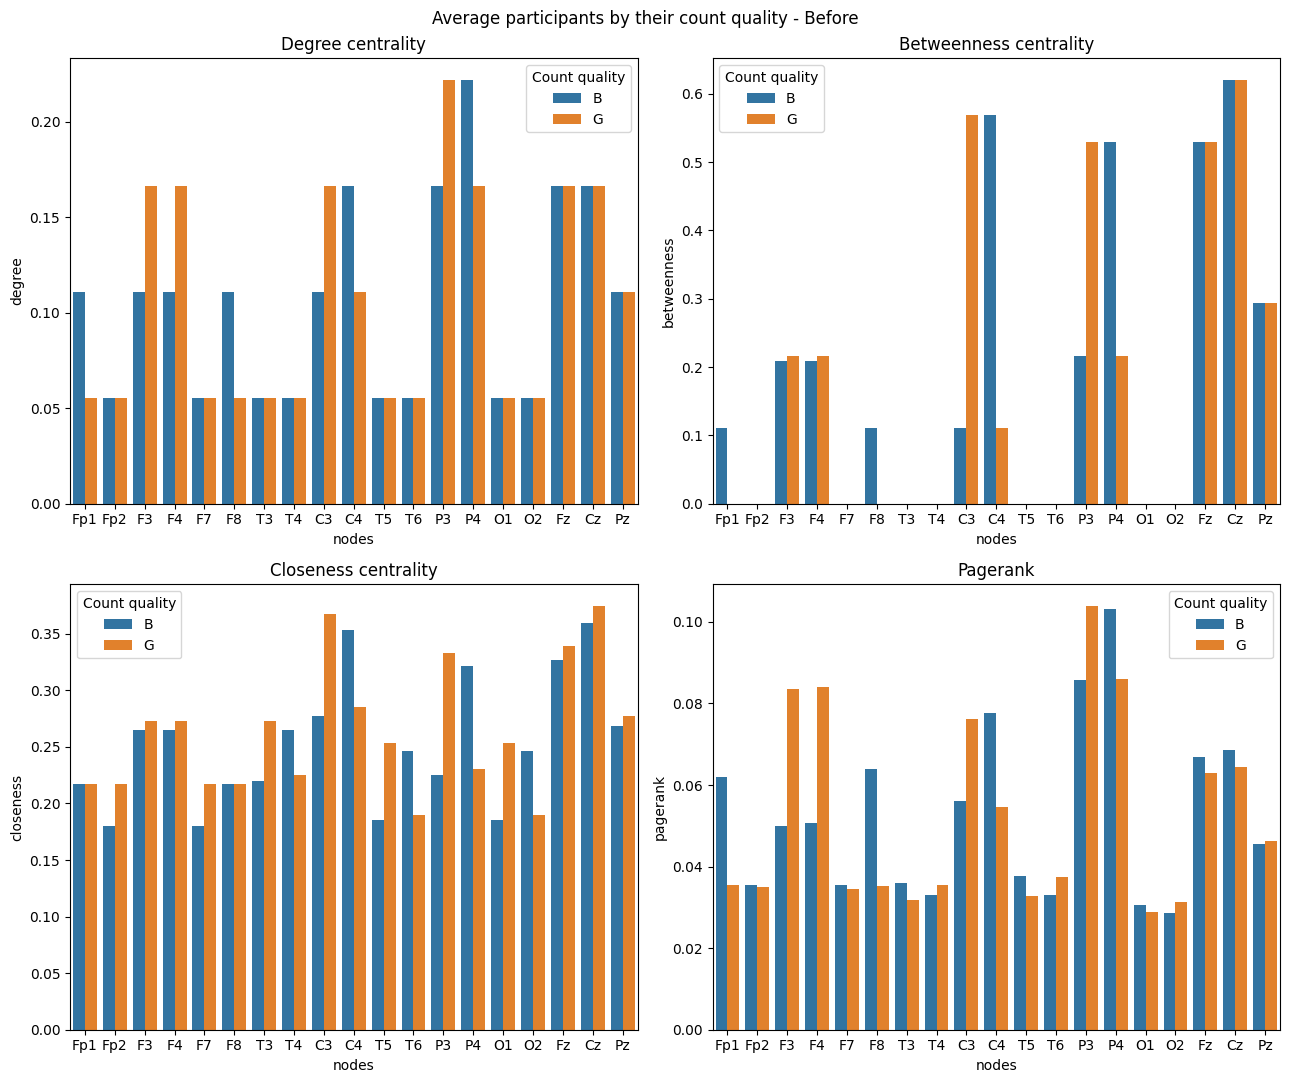

In [ ]:
df_temp1 = df_centrality_ave_counts[df_centrality_ave_counts['status'] == 'before']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Average participants by their count quality - Before')

ax1.set_title('Degree centrality')
sns.barplot(
    df_temp1, x='nodes', y='degree', hue='Count quality', ax=ax1
)

ax2.set_title('Betweenness centrality')
sns.barplot(    
    df_temp1, x='nodes', y='betweenness', hue='Count quality', ax=ax2
)

ax3.set_title('Closeness centrality')
sns.barplot(
    df_temp1, x='nodes', y='closeness', hue='Count quality', ax=ax3
)

ax4.set_title('Pagerank')
sns.barplot(
    df_temp1, x='nodes', y='pagerank', hue='Count quality', ax=ax4
)

plt.tight_layout()

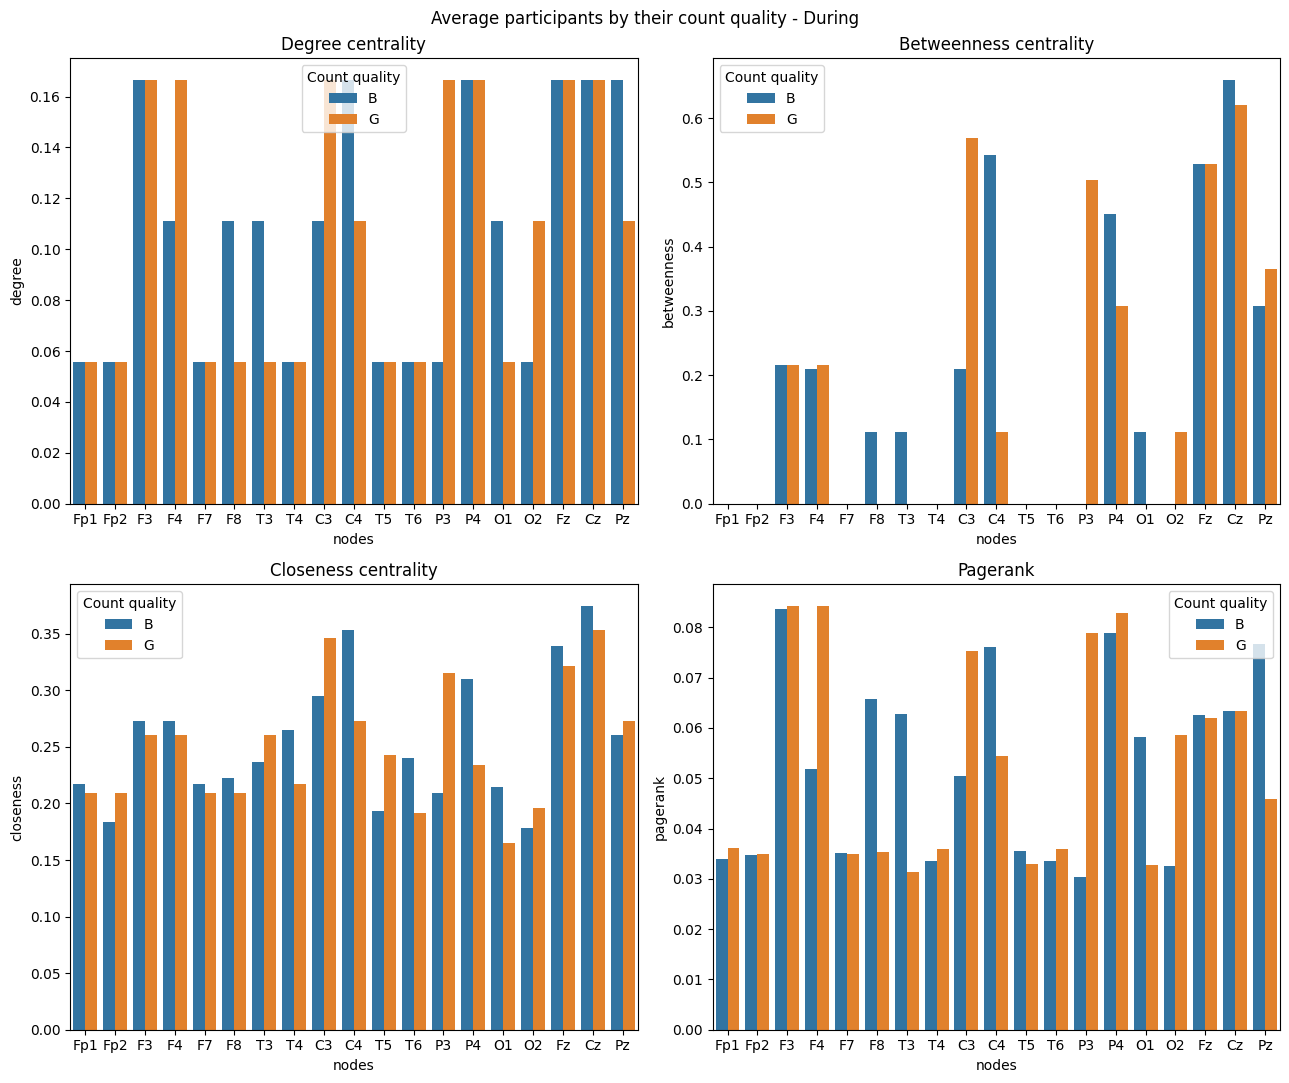

In [ ]:
df_temp1 = df_centrality_ave_counts[df_centrality_ave_counts['status'] == 'during']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Average participants by their count quality - During')

ax1.set_title('Degree centrality')
sns.barplot(
    df_temp1, x='nodes', y='degree', hue='Count quality', ax=ax1
)

ax2.set_title('Betweenness centrality')
sns.barplot(
    df_temp1, x='nodes', y='betweenness', hue='Count quality', ax=ax2
)

ax3.set_title('Closeness centrality')
sns.barplot(
    df_temp1, x='nodes', y='closeness', hue='Count quality', ax=ax3
)

ax4.set_title('Pagerank')
sns.barplot(
    df_temp1, x='nodes', y='pagerank', hue='Count quality', ax=ax4
)

plt.tight_layout()